# Introduction

Using SBERT, BERT, and GPT, each model was trained on both the sentence level and entire policy level using the labeled OPP-115 dataset. The models were then saved and subsequently tested on unlabeled policies from the ACL Coling dataset to assess their generalizability and performance.

In [ ]:
device = 'cuda'
import torch, gc
import os
gc.collect()
torch.cuda.empty_cache()


In [ ]:
!pip install sentence-transformers
!pip install -U transformers
!pip install accelerate -U
!pip install nltk
!pip install tqdm
!pip install spacy beautifulsoup4
!pip -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install openai
!pip install rich


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
# all imports
import pandas as pd
import ast
import torch
from torch import nn
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import spacy
import gensim
import nltk
from tqdm import tqdm
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
from openai import OpenAI
from rich.console import Console
from rich.markdown import Markdown
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from transformers import pipeline
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from transformers import GPT2ForSequenceClassification
from transformers import GPT2Tokenizer, GPT2Model
from sentence_transformers import SentenceTransformer
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorboard.backend.event_processing import event_accumulator



In [ ]:
%env OPENAI_API_KEY=...


In [ ]:
!unzip ./OPP-115_v1_0.zip -d ./OPP-115
!unzip /content/acl-coling-2014-corpus.zip -d /content/acl_corpus



Streaming output truncated to the last 5000 lines.
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/seg(1)  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/setuid  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/share2quote.css  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/show_companion_ad.js  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/signup_confirm.css  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/Sin-Nombre-Cocktail-Don-Julio.jpg  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/small-logo.png  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/smarter-than-a-bartender.css  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/style.css  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/tap.php  
  inflating: ./OPP-115/OPP-115/original_policies/59_liquor.com_files/teE3

In [ ]:
# OPP-115 Categories
opp_categories = [
    "First Party Collection/Use",
    "Third Party Sharing/Collection",
    "User Choice/Control",
    "User Access, Edit, and Deletion",
    "Data Retention",
    "Data Security",
    "Policy Change",
    "Do Not Track",
    "International and Specific Audiences",
    "Other"
]

# GDPR Article 5 Principles
gdpr_principles = [
    "lawfulness, fairness and transparency",
    "purpose limitation",
    "data minimisation",
    "accuracy",
    "storage limitation",
    "integrity and confidentiality",
    "accountability"
]

In [ ]:
# OPP-115 Categories
opp_categories = [
    "First Party Collection/Use: how and why a service provider collects user information.",
    "Third Party Sharing/Collection: how user information may be shared with or collected by third parties.",
    "User Choice/Control: choices and control options available to users.",
    "User Access, Edit, & Deletion: if and how users may access, edit, or delete their information.",
    "Data Retention: how long user information is stored.",
    "Data Security: how user information is protected.",
    "Policy Change: if and how users will be informed about changes to the privacy policy.",
    "Do Not Track: if and how Do Not Track signals for online tracking and advertising are honored.",
    "International & Specific Audiences: practices that pertain only to a specific group of users (e.g., children, Europeans, or California residents).",
    "Other: additional sub-labels for introductory or general text, contact information, and practices not covered by the other categories."
]

# GDPR Article 5 Principles
gdpr_principles = [
    "Lawfulness, Fairness and Transparency: processed lawfully, fairly and in a transparent manner",
    "Purpose Limitation: collected for specified, explicit and legitimate purposes and not further processed in a manner that is incompatible with those purposes",
    "Data Minimisation: adequate, relevant and limited to what is necessary",
    "Accuracy: accurate and, where necessary, kept up to date",
    "Storage Limitation: kept in a form which permits identification of data subjects for no longer than necessary",
    "Integrity and Confidentiality: processed in a manner that ensures security of the data",
    "Accountability: the controller shall be responsible for and be able to demonstrate compliance"
]


In [ ]:
gdpr_article_5_text = """
                      1. Personal data shall be:
                      a) processed lawfully, fairly and in a transparent manner in relation to the data subject (‘lawfulness, fairness and transparency’);
                      b) collected for specified, explicit and legitimate purposes and not further processed in a manner that is incompatible with those purposes; further processing for archiving purposes in the public interest, scientific or historical research purposes or statistical purposes shall, in accordance with Article 89(1), not be considered to be incompatible with the initial purposes (‘purpose limitation’);
                      c) adequate, relevant and limited to what is necessary in relation to the purposes for which they are processed (‘data minimisation’);
                      d) accurate and, where necessary, kept up to date; every reasonable step must be taken to ensure that personal data that are inaccurate, having regard to the purposes for which they are processed, are erased or rectified without delay (‘accuracy’);
                      e) kept in a form which permits identification of data subjects for no longer than is necessary for the purposes for which the personal data are processed; personal data may be stored for longer periods insofar as the personal data will be processed solely for archiving purposes in the public interest, scientific or historical research purposes or statistical purposes in accordance with Article 89(1) subject to implementation of the appropriate technical and organisational measures required by this Regulation in order to safeguard the rights and freedoms of the data subject (‘storage limitation’);
                      f) processed in a manner that ensures appropriate security of the personal data, including protection against unauthorised or unlawful processing and against accidental loss, destruction or damage, using appropriate technical or organisational measures (‘integrity and confidentiality’).
                      2. The controller shall be responsible for, and be able to demonstrate compliance with, paragraph 1 (‘accountability’).
                      """

In [ ]:
sbert_label_descriptions = {
    0: "Lawfulness, Fairness and Transparency",
    1: "Purpose Limitation",
    2: "Data Minimization",
    3: "Accuracy",
    4: "Storage Limitation",
    5: "Integrity and Confidentiality",
    6: "Accountability",
}


In [ ]:
label_descriptions = {
    "LABEL_0": "Lawfulness, Fairness, and Transparency",
    "LABEL_1": "Purpose Limitation",
    "LABEL_2": "Data Minimization",
    "LABEL_3": "Accuracy",
    "LABEL_4": "Storage Limitation",
    "LABEL_5": "Integrity and Confidentiality (Security)",
    "LABEL_6": "Accountability"
}



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
nlp = spacy.load("en_core_web_sm")


In [ ]:
def display_open_ai_response(response):
  console = Console()

  # using markdown to format the response
  md = Markdown(response)

  console.print(md)

# Single Policy

In [ ]:
single_principle_df = pd.read_csv('./sentences_gdpr_label_4.csv')
single_principle_df = single_principle_df[single_principle_df['is_included'] == True]
single_principle_df.reset_index(drop=True, inplace=True)
single_principle_df['sentence_label'] = single_principle_df['sentence_label'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
single_principle_df.head()


policy_name  sentence_id  \
0  898_uptodate.com            0   
1  898_uptodate.com            1   
2  898_uptodate.com            2   
3  898_uptodate.com            3   
4  898_uptodate.com            4   

                                       sentence_text  sentence_label  \
0       UpToDate online privacy policy UpToDate Inc.               0   
1   is very sensitive to the privacy needs of its...               0   
2   UpToDate does not sell or otherwise share sub...               0   
3   To better understand UpToDate s online privac...               0   
4   Subscriber Information UpToDate never automat...               0   

   sentence_length  is_included  
0                6         True  
1               25         True  
2               16         True  
3               15         True  
4               22         True

## OPP-115 Dataset

In [ ]:
# Count the number of rows where 'sentence_label' is 1
count_label_1 = single_principle_df['sentence_label'].sum()

print(f"Number of sentences that adhere to the specific GDPR principle: {count_label_1}")


Number of sentences that adhere to the specific GDPR principle: 342


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Assuming 'single_principle_df' is your DataFrame and it contains the text and labels
texts = single_principle_df['sentence_text'].values
labels = single_principle_df['sentence_label'].values.reshape(-1, 1)  # reshaping for compatibility

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
texts_resampled, labels_resampled = ros.fit_resample(texts.reshape(-1, 1), labels)

# Convert resampled data back to the correct structure
single_principle_df_resampled = pd.DataFrame({
    'sentence_text': texts_resampled.flatten(),
    'sentence_label': labels_resampled.flatten()
})
single_principle_df_resampled.head()



sentence_text  sentence_label
0       UpToDate online privacy policy UpToDate Inc.               0
1   is very sensitive to the privacy needs of its...               0
2   UpToDate does not sell or otherwise share sub...               0
3   To better understand UpToDate s online privac...               0
4   Subscriber Information UpToDate never automat...               0

In [ ]:
# Count the number of rows where 'sentence_label' is 1
count_label_1 = single_principle_df_resampled['sentence_label'].sum()

print(f"Percentage of sentences that adhere to the specific GDPR principle: {count_label_1/len(single_principle_df_resampled)*100:.2f}")


Percentage of sentences that adhere to the specific GDPR principle: 50.00


### SBERT

In [ ]:
# load SBERT model
sentence_sbert_single_principle_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_sbert_single_principle_generate_embeddings(texts):
    embeddings = sentence_sbert_single_principle_model.encode(texts, convert_to_tensor=True)
    return embeddings

def sentence_sbert_single_principle_calculate_metrics(preds, labels, threshold):
    preds = preds > threshold
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)
    return accuracy, precision, recall, f1


class SBERTSinglePrincipleEmbeddingDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = sentence_sbert_single_principle_generate_embeddings(texts)
        self.labels = torch.tensor(labels, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': self.labels[idx]
        }

# Modify the train function to handle binary classification
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, threshold):
    history = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for epoch in tqdm(range(epochs), "training..."):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_eval_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        accuracy, precision, recall, f1 = sentence_sbert_single_principle_calculate_metrics(all_preds, all_labels, threshold)

        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    return model, history

# Calculate class weights and adjust for binary classification
class_counts = [np.sum(single_principle_df_resampled['sentence_label'] == 0), np.sum(single_principle_df_resampled['sentence_label'] == 1)]
total_samples = len(single_principle_df_resampled['sentence_label'])

# Calculate class weights for binary classification
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]

# Convert class weights to tensor, focusing on positive class weight only since it's binary classification
weights_tensor = torch.tensor([class_weights[1]], dtype=torch.float, device=device)  # Only need weight for the positive class

# Initialize the criterion with pos_weight
sentence_sbert_single_principle_criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)

# Define your SBERTEmbeddingDataset, DataLoader, and Model setup
sentence_sbert_single_principle_dataset = SBERTSinglePrincipleEmbeddingDataset(single_principle_df_resampled['sentence_text'].tolist(), single_principle_df_resampled['sentence_label'].tolist())
sentence_sbert_single_principle_train_dataset, sentence_sbert_single_principle_eval_dataset = train_test_split(sentence_sbert_single_principle_dataset, test_size=0.2)

class SBertSinglePrincipleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256):
        super(SBertSinglePrincipleClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.fc = nn.Linear(2 * hidden_dim, 1)  # Output a single value

    def attention_net(self, lstm_output):
        """ Attention mechanism to weigh the importance of LSTM outputs """
        attention_scores = torch.tanh(self.attention(lstm_output))
        return torch.softmax(attention_scores, dim=1)

    def forward(self, embeddings):
        lstm_out, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        attention_weights = self.attention_net(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.fc(context_vector)
        return out

# Initialize and train the model
embedding_dim = sentence_sbert_single_principle_model.get_sentence_embedding_dimension()
sentence_sbert_single_principle_classifier_model = SBertSinglePrincipleClassifier(embedding_dim).to(device)
sentence_sbert_single_principle_optimizer = Adam(sentence_sbert_single_principle_classifier_model.parameters(), lr=1e-5)
sentence_sbert_single_principle_train_loader = DataLoader(sentence_sbert_single_principle_train_dataset, batch_size=16, shuffle=True)
sentence_sbert_single_principle_val_loader = DataLoader(sentence_sbert_single_principle_eval_dataset, batch_size=16, shuffle=False)

# # Train the model
# trained_model, sbert_process_history = train(sentence_sbert_single_principle_classifier_model, sentence_sbert_train_loader,
#                       sentence_sbert_val_loader, sentence_sbert_optimizer,
#                       sentence_sbert_criterion, epochs=25, device=device)

# Experiment with different learning rates
learning_rates = [5e-5, 2e-5, 1e-5, 1e-4]

# Experiment with different epochs
epoch_counts = [5, 10, 15]

# Experiment with different thresholds
thresholds = [0.3, 0.5, 0.7, 0.8]

best_f1 = 0
best_model = None

for lr in tqdm(learning_rates):
    for epochs in epoch_counts:
        for threshold in thresholds:
            print(f"Training with learning rate: {lr}, epochs: {epochs}, threshold: {threshold}")
            sentence_sbert_single_principle_classifier_model = SBertSinglePrincipleClassifier(embedding_dim).to(device)
            sentence_sbert_optimizer = Adam(sentence_sbert_single_principle_classifier_model.parameters(), lr=lr)
            trained_model, sbert_process_history = train(sentence_sbert_single_principle_classifier_model, sentence_sbert_single_principle_train_loader,
                                sentence_sbert_single_principle_val_loader, sentence_sbert_single_principle_optimizer,
                                sentence_sbert_single_principle_criterion, epochs=epochs, device=device, threshold=threshold)
            current_f1 = sbert_process_history['f1'][-1]
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_model = trained_model

print(f"Best model F1 score: {best_f1}")


  0%|          | 0/4 [00:00<?, ?it/s]

Training with learning rate: 5e-05, epochs: 5, threshold: 0.3



training...:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

Epoch 1: Train Loss: 1.0372, Val Loss: 1.0369
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 2/5 [00:05<00:08,  2.95s/it]

Epoch 2: Train Loss: 1.0372, Val Loss: 1.0369
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

Epoch 3: Train Loss: 1.0372, Val Loss: 1.0369
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

Epoch 4: Train Loss: 1.0372, Val Loss: 1.0369
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch 5: Train Loss: 1.0372, Val Loss: 1.0369
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 5e-05, epochs: 5, threshold: 0.5



training...:  20%|██        | 1/5 [00:02<00:10,  2.70s/it]

Epoch 1: Train Loss: 1.0361, Val Loss: 1.0358
Accuracy: 0.5010, Precision: 0.5006, Recall: 1.0000, F1: 0.6672



training...:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

Epoch 2: Train Loss: 1.0361, Val Loss: 1.0358
Accuracy: 0.5010, Precision: 0.5006, Recall: 1.0000, F1: 0.6672



training...:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

Epoch 3: Train Loss: 1.0361, Val Loss: 1.0358
Accuracy: 0.5010, Precision: 0.5006, Recall: 1.0000, F1: 0.6672



training...:  80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

Epoch 4: Train Loss: 1.0361, Val Loss: 1.0358
Accuracy: 0.5010, Precision: 0.5006, Recall: 1.0000, F1: 0.6672



training...: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 5: Train Loss: 1.0361, Val Loss: 1.0358
Accuracy: 0.5010, Precision: 0.5006, Recall: 1.0000, F1: 0.6672
Training with learning rate: 5e-05, epochs: 5, threshold: 0.7



training...:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

Epoch 1: Train Loss: 1.0419, Val Loss: 1.0416
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

Epoch 2: Train Loss: 1.0419, Val Loss: 1.0416
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

Epoch 3: Train Loss: 1.0419, Val Loss: 1.0416
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

Epoch 4: Train Loss: 1.0419, Val Loss: 1.0416
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 5: Train Loss: 1.0419, Val Loss: 1.0416
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 5e-05, epochs: 5, threshold: 0.8



training...:  20%|██        | 1/5 [00:02<00:11,  2.75s/it]

Epoch 1: Train Loss: 1.0395, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

Epoch 2: Train Loss: 1.0395, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

Epoch 3: Train Loss: 1.0395, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

Epoch 4: Train Loss: 1.0395, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 5: Train Loss: 1.0395, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 5e-05, epochs: 10, threshold: 0.3



training...:  10%|█         | 1/10 [00:02<00:24,  2.70s/it]

Epoch 1: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 2/10 [00:05<00:21,  2.71s/it]

Epoch 2: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  30%|███       | 3/10 [00:08<00:18,  2.71s/it]

Epoch 3: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 4/10 [00:10<00:16,  2.70s/it]

Epoch 4: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Epoch 5: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 6/10 [00:16<00:10,  2.72s/it]

Epoch 6: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

Epoch 7: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 8/10 [00:21<00:05,  2.73s/it]

Epoch 8: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.74s/it]

Epoch 9: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Epoch 10: Train Loss: 1.0421, Val Loss: 1.0419
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 5e-05, epochs: 10, threshold: 0.5



training...:  10%|█         | 1/10 [00:02<00:24,  2.72s/it]

Epoch 1: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.75s/it]

Epoch 2: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Epoch 3: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Epoch 4: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.77s/it]

Epoch 5: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:11,  2.76s/it]

Epoch 6: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Epoch 7: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Epoch 8: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.78s/it]

Epoch 9: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Epoch 10: Train Loss: 1.0428, Val Loss: 1.0425
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 5e-05, epochs: 10, threshold: 0.7



training...:  10%|█         | 1/10 [00:02<00:24,  2.75s/it]

Epoch 1: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.75s/it]

Epoch 2: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.79s/it]

Epoch 3: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:11<00:16,  2.77s/it]

Epoch 4: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.75s/it]

Epoch 5: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:10,  2.75s/it]

Epoch 6: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.77s/it]

Epoch 7: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

Epoch 8: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

Epoch 9: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Epoch 10: Train Loss: 1.0340, Val Loss: 1.0338
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 5e-05, epochs: 10, threshold: 0.8



training...:  10%|█         | 1/10 [00:02<00:24,  2.75s/it]

Epoch 1: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:22,  2.78s/it]

Epoch 2: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.77s/it]

Epoch 3: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Epoch 4: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.77s/it]

Epoch 5: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:11,  2.78s/it]

Epoch 6: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

Epoch 7: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Epoch 8: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

Epoch 9: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


Epoch 10: Train Loss: 1.0367, Val Loss: 1.0364
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 5e-05, epochs: 15, threshold: 0.3



training...:   7%|▋         | 1/15 [00:02<00:39,  2.80s/it]

Epoch 1: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.75s/it]

Epoch 2: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:33,  2.76s/it]

Epoch 3: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.79s/it]

Epoch 4: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.78s/it]

Epoch 5: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:24,  2.76s/it]

Epoch 6: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.75s/it]

Epoch 7: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.77s/it]

Epoch 8: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:24<00:16,  2.76s/it]

Epoch 9: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.76s/it]

Epoch 10: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.77s/it]

Epoch 11: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:33<00:08,  2.78s/it]

Epoch 12: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:36<00:05,  2.78s/it]

Epoch 13: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.78s/it]

Epoch 14: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:41<00:00,  2.77s/it]


Epoch 15: Train Loss: 1.0349, Val Loss: 1.0346
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 5e-05, epochs: 15, threshold: 0.5



training...:   7%|▋         | 1/15 [00:02<00:39,  2.82s/it]

Epoch 1: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:36,  2.81s/it]

Epoch 2: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:33,  2.78s/it]

Epoch 3: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.75s/it]

Epoch 4: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.76s/it]

Epoch 5: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:25,  2.79s/it]

Epoch 6: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.78s/it]

Epoch 7: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.78s/it]

Epoch 8: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:24<00:16,  2.76s/it]

Epoch 9: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.78s/it]

Epoch 10: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.78s/it]

Epoch 11: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:33<00:08,  2.77s/it]

Epoch 12: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:36<00:05,  2.79s/it]

Epoch 13: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.80s/it]

Epoch 14: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:41<00:00,  2.78s/it]


Epoch 15: Train Loss: 1.0326, Val Loss: 1.0323
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 5e-05, epochs: 15, threshold: 0.7



training...:   7%|▋         | 1/15 [00:02<00:38,  2.75s/it]

Epoch 1: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.75s/it]

Epoch 2: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:33,  2.76s/it]

Epoch 3: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.77s/it]

Epoch 4: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.77s/it]

Epoch 5: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.77s/it]

Epoch 6: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.76s/it]

Epoch 7: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.77s/it]

Epoch 8: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.76s/it]

Epoch 9: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.76s/it]

Epoch 10: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:30<00:10,  2.75s/it]

Epoch 11: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:33<00:08,  2.76s/it]

Epoch 12: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.75s/it]

Epoch 13: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.75s/it]

Epoch 14: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 15/15 [00:41<00:00,  2.76s/it]


Epoch 15: Train Loss: 1.0322, Val Loss: 1.0320
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 5e-05, epochs: 15, threshold: 0.8



training...:   7%|▋         | 1/15 [00:02<00:38,  2.76s/it]

Epoch 1: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]

Epoch 2: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:33,  2.76s/it]

Epoch 3: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.76s/it]

Epoch 4: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.76s/it]

Epoch 5: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.76s/it]

Epoch 6: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.76s/it]

Epoch 7: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.76s/it]

Epoch 8: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.76s/it]

Epoch 9: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.76s/it]

Epoch 10: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.77s/it]

Epoch 11: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:33<00:08,  2.78s/it]

Epoch 12: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.76s/it]

Epoch 13: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.77s/it]

Epoch 14: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



 25%|██▌       | 1/4 [05:32<16:36, 332.16s/it]

Epoch 15: Train Loss: 1.0364, Val Loss: 1.0360
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 2e-05, epochs: 5, threshold: 0.3



training...:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

Epoch 1: Train Loss: 1.0386, Val Loss: 1.0383
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

Epoch 2: Train Loss: 1.0386, Val Loss: 1.0383
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

Epoch 3: Train Loss: 1.0386, Val Loss: 1.0383
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

Epoch 4: Train Loss: 1.0386, Val Loss: 1.0383
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 5: Train Loss: 1.0386, Val Loss: 1.0383
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 2e-05, epochs: 5, threshold: 0.5



training...:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

Epoch 1: Train Loss: 1.0363, Val Loss: 1.0360
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

Epoch 2: Train Loss: 1.0363, Val Loss: 1.0360
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

Epoch 3: Train Loss: 1.0363, Val Loss: 1.0360
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

Epoch 4: Train Loss: 1.0363, Val Loss: 1.0360
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch 5: Train Loss: 1.0363, Val Loss: 1.0360
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 2e-05, epochs: 5, threshold: 0.7



training...:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Epoch 1: Train Loss: 1.0394, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

Epoch 2: Train Loss: 1.0394, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

Epoch 3: Train Loss: 1.0394, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

Epoch 4: Train Loss: 1.0394, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Epoch 5: Train Loss: 1.0394, Val Loss: 1.0391
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 2e-05, epochs: 5, threshold: 0.8



training...:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

Epoch 1: Train Loss: 1.0315, Val Loss: 1.0312
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.76s/it]

Epoch 2: Train Loss: 1.0315, Val Loss: 1.0312
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

Epoch 3: Train Loss: 1.0315, Val Loss: 1.0312
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

Epoch 4: Train Loss: 1.0315, Val Loss: 1.0312
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 5: Train Loss: 1.0315, Val Loss: 1.0312
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 2e-05, epochs: 10, threshold: 0.3



training...:  10%|█         | 1/10 [00:02<00:24,  2.72s/it]

Epoch 1: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 2/10 [00:05<00:21,  2.74s/it]

Epoch 2: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Epoch 3: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 4/10 [00:10<00:16,  2.75s/it]

Epoch 4: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  50%|█████     | 5/10 [00:13<00:13,  2.77s/it]

Epoch 5: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 6/10 [00:16<00:11,  2.76s/it]

Epoch 6: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Epoch 7: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

Epoch 8: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.79s/it]

Epoch 9: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Epoch 10: Train Loss: 1.0475, Val Loss: 1.0472
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 2e-05, epochs: 10, threshold: 0.5



training...:  10%|█         | 1/10 [00:02<00:24,  2.75s/it]

Epoch 1: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 2/10 [00:05<00:22,  2.75s/it]

Epoch 2: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  30%|███       | 3/10 [00:08<00:19,  2.77s/it]

Epoch 3: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Epoch 4: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  50%|█████     | 5/10 [00:13<00:13,  2.75s/it]

Epoch 5: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 6/10 [00:16<00:11,  2.76s/it]

Epoch 6: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  70%|███████   | 7/10 [00:19<00:08,  2.79s/it]

Epoch 7: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Epoch 8: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.78s/it]

Epoch 9: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Epoch 10: Train Loss: 1.0277, Val Loss: 1.0273
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 2e-05, epochs: 10, threshold: 0.7



training...:  10%|█         | 1/10 [00:02<00:25,  2.83s/it]

Epoch 1: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

Epoch 2: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.77s/it]

Epoch 3: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Epoch 4: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.76s/it]

Epoch 5: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:11,  2.76s/it]

Epoch 6: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

Epoch 7: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:22<00:05,  2.75s/it]

Epoch 8: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.74s/it]

Epoch 9: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Epoch 10: Train Loss: 1.0411, Val Loss: 1.0408
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 2e-05, epochs: 10, threshold: 0.8



training...:  10%|█         | 1/10 [00:02<00:24,  2.71s/it]

Epoch 1: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.73s/it]

Epoch 2: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Epoch 3: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:10<00:16,  2.75s/it]

Epoch 4: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Epoch 5: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Epoch 6: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

Epoch 7: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:21<00:05,  2.76s/it]

Epoch 8: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

Epoch 9: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Epoch 10: Train Loss: 1.0329, Val Loss: 1.0328
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 2e-05, epochs: 15, threshold: 0.3



training...:   7%|▋         | 1/15 [00:02<00:38,  2.77s/it]

Epoch 1: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]

Epoch 2: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:32,  2.75s/it]

Epoch 3: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:10<00:30,  2.74s/it]

Epoch 4: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.74s/it]

Epoch 5: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:24,  2.75s/it]

Epoch 6: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.76s/it]

Epoch 7: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.75s/it]

Epoch 8: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:24<00:16,  2.74s/it]

Epoch 9: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.73s/it]

Epoch 10: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:30<00:10,  2.74s/it]

Epoch 11: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:32<00:08,  2.73s/it]

Epoch 12: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.72s/it]

Epoch 13: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.72s/it]

Epoch 14: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


Epoch 15: Train Loss: 1.0365, Val Loss: 1.0361
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 2e-05, epochs: 15, threshold: 0.5



training...:   7%|▋         | 1/15 [00:02<00:37,  2.70s/it]

Epoch 1: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.71s/it]

Epoch 2: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:32,  2.73s/it]

Epoch 3: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:10<00:30,  2.74s/it]

Epoch 4: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.74s/it]

Epoch 5: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:24,  2.74s/it]

Epoch 6: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:21,  2.73s/it]

Epoch 7: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:21<00:19,  2.73s/it]

Epoch 8: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:24<00:16,  2.73s/it]

Epoch 9: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.71s/it]

Epoch 10: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:29<00:10,  2.71s/it]

Epoch 11: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:32<00:08,  2.71s/it]

Epoch 12: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.71s/it]

Epoch 13: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.71s/it]

Epoch 14: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:40<00:00,  2.72s/it]


Epoch 15: Train Loss: 1.0338, Val Loss: 1.0337
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 2e-05, epochs: 15, threshold: 0.7



training...:   7%|▋         | 1/15 [00:02<00:36,  2.64s/it]

Epoch 1: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.71s/it]

Epoch 2: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:32,  2.71s/it]

Epoch 3: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:10<00:29,  2.71s/it]

Epoch 4: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.72s/it]

Epoch 5: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.71s/it]

Epoch 6: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:18<00:21,  2.72s/it]

Epoch 7: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:21<00:18,  2.70s/it]

Epoch 8: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.70s/it]

Epoch 9: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.70s/it]

Epoch 10: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:29<00:10,  2.71s/it]

Epoch 11: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:32<00:08,  2.70s/it]

Epoch 12: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.70s/it]

Epoch 13: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:37<00:02,  2.69s/it]

Epoch 14: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 15/15 [00:40<00:00,  2.70s/it]


Epoch 15: Train Loss: 1.0438, Val Loss: 1.0434
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 2e-05, epochs: 15, threshold: 0.8



training...:   7%|▋         | 1/15 [00:02<00:38,  2.72s/it]

Epoch 1: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.71s/it]

Epoch 2: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:32,  2.68s/it]

Epoch 3: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:10<00:29,  2.69s/it]

Epoch 4: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:26,  2.69s/it]

Epoch 5: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.68s/it]

Epoch 6: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:18<00:21,  2.68s/it]

Epoch 7: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:21<00:18,  2.70s/it]

Epoch 8: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.71s/it]

Epoch 9: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:26<00:13,  2.70s/it]

Epoch 10: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:29<00:10,  2.69s/it]

Epoch 11: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:32<00:08,  2.70s/it]

Epoch 12: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.72s/it]

Epoch 13: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:37<00:02,  2.72s/it]

Epoch 14: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



 50%|█████     | 2/4 [11:00<11:00, 330.16s/it]

Epoch 15: Train Loss: 1.0508, Val Loss: 1.0504
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 5, threshold: 0.3



training...:  20%|██        | 1/5 [00:02<00:10,  2.69s/it]

Epoch 1: Train Loss: 1.0481, Val Loss: 1.0478
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 2/5 [00:05<00:08,  2.70s/it]

Epoch 2: Train Loss: 1.0481, Val Loss: 1.0478
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

Epoch 3: Train Loss: 1.0481, Val Loss: 1.0478
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

Epoch 4: Train Loss: 1.0481, Val Loss: 1.0478
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 5: Train Loss: 1.0481, Val Loss: 1.0478
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 1e-05, epochs: 5, threshold: 0.5



training...:  20%|██        | 1/5 [00:02<00:10,  2.67s/it]

Epoch 1: Train Loss: 1.0305, Val Loss: 1.0304
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

Epoch 2: Train Loss: 1.0305, Val Loss: 1.0304
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

Epoch 3: Train Loss: 1.0305, Val Loss: 1.0304
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

Epoch 4: Train Loss: 1.0305, Val Loss: 1.0304
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 5: Train Loss: 1.0305, Val Loss: 1.0304
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 1e-05, epochs: 5, threshold: 0.7



training...:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

Epoch 1: Train Loss: 1.0423, Val Loss: 1.0419
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.74s/it]

Epoch 2: Train Loss: 1.0423, Val Loss: 1.0419
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

Epoch 3: Train Loss: 1.0423, Val Loss: 1.0419
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

Epoch 4: Train Loss: 1.0423, Val Loss: 1.0419
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 5: Train Loss: 1.0423, Val Loss: 1.0419
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 5, threshold: 0.8



training...:  20%|██        | 1/5 [00:02<00:10,  2.75s/it]

Epoch 1: Train Loss: 1.0398, Val Loss: 1.0396
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.77s/it]

Epoch 2: Train Loss: 1.0398, Val Loss: 1.0396
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

Epoch 3: Train Loss: 1.0398, Val Loss: 1.0396
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

Epoch 4: Train Loss: 1.0398, Val Loss: 1.0396
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 5: Train Loss: 1.0398, Val Loss: 1.0396
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 10, threshold: 0.3



training...:  10%|█         | 1/10 [00:02<00:24,  2.76s/it]

Epoch 1: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 2/10 [00:05<00:22,  2.77s/it]

Epoch 2: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Epoch 3: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 4/10 [00:11<00:16,  2.77s/it]

Epoch 4: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  50%|█████     | 5/10 [00:13<00:13,  2.75s/it]

Epoch 5: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 6/10 [00:16<00:10,  2.73s/it]

Epoch 6: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

Epoch 7: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

Epoch 8: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.75s/it]

Epoch 9: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Epoch 10: Train Loss: 1.0509, Val Loss: 1.0506
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 1e-05, epochs: 10, threshold: 0.5



training...:  10%|█         | 1/10 [00:02<00:24,  2.73s/it]

Epoch 1: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.74s/it]

Epoch 2: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Epoch 3: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:10<00:16,  2.73s/it]

Epoch 4: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.73s/it]

Epoch 5: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:10,  2.73s/it]

Epoch 6: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Epoch 7: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

Epoch 8: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.75s/it]

Epoch 9: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Epoch 10: Train Loss: 1.0464, Val Loss: 1.0461
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 10, threshold: 0.7



training...:  10%|█         | 1/10 [00:02<00:24,  2.76s/it]

Epoch 1: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.72s/it]

Epoch 2: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Epoch 3: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:10<00:16,  2.72s/it]

Epoch 4: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.73s/it]

Epoch 5: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:10,  2.71s/it]

Epoch 6: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Epoch 7: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:21<00:05,  2.72s/it]

Epoch 8: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

Epoch 9: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Epoch 10: Train Loss: 1.0467, Val Loss: 1.0464
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 10, threshold: 0.8



training...:  10%|█         | 1/10 [00:02<00:24,  2.73s/it]

Epoch 1: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Epoch 2: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Epoch 3: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:10<00:16,  2.74s/it]

Epoch 4: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.72s/it]

Epoch 5: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:10,  2.72s/it]

Epoch 6: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Epoch 7: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:21<00:05,  2.75s/it]

Epoch 8: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.74s/it]

Epoch 9: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Epoch 10: Train Loss: 1.0537, Val Loss: 1.0534
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 15, threshold: 0.3



training...:   7%|▋         | 1/15 [00:02<00:38,  2.73s/it]

Epoch 1: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]

Epoch 2: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:33,  2.75s/it]

Epoch 3: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.76s/it]

Epoch 4: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.76s/it]

Epoch 5: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:24,  2.75s/it]

Epoch 6: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:21,  2.75s/it]

Epoch 7: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:21<00:19,  2.72s/it]

Epoch 8: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:24<00:16,  2.72s/it]

Epoch 9: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.71s/it]

Epoch 10: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:30<00:10,  2.73s/it]

Epoch 11: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:32<00:08,  2.75s/it]

Epoch 12: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.76s/it]

Epoch 13: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.77s/it]

Epoch 14: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:41<00:00,  2.76s/it]


Epoch 15: Train Loss: 1.0391, Val Loss: 1.0388
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 1e-05, epochs: 15, threshold: 0.5



training...:   7%|▋         | 1/15 [00:02<00:39,  2.80s/it]

Epoch 1: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]

Epoch 2: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  20%|██        | 3/15 [00:08<00:33,  2.75s/it]

Epoch 3: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.76s/it]

Epoch 4: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.76s/it]

Epoch 5: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  40%|████      | 6/15 [00:16<00:24,  2.76s/it]

Epoch 6: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.76s/it]

Epoch 7: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.75s/it]

Epoch 8: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  60%|██████    | 9/15 [00:24<00:16,  2.79s/it]

Epoch 9: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.80s/it]

Epoch 10: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.78s/it]

Epoch 11: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  80%|████████  | 12/15 [00:33<00:08,  2.77s/it]

Epoch 12: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  87%|████████▋ | 13/15 [00:36<00:05,  2.79s/it]

Epoch 13: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.80s/it]

Epoch 14: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659



training...: 100%|██████████| 15/15 [00:41<00:00,  2.78s/it]


Epoch 15: Train Loss: 1.0371, Val Loss: 1.0369
Accuracy: 0.4995, Precision: 0.4999, Recall: 0.9971, F1: 0.6659
Training with learning rate: 1e-05, epochs: 15, threshold: 0.7



training...:   7%|▋         | 1/15 [00:02<00:38,  2.72s/it]

Epoch 1: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.75s/it]

Epoch 2: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:33,  2.75s/it]

Epoch 3: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.76s/it]

Epoch 4: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.75s/it]

Epoch 5: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.76s/it]

Epoch 6: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:19<00:21,  2.74s/it]

Epoch 7: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:21<00:19,  2.74s/it]

Epoch 8: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.74s/it]

Epoch 9: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.76s/it]

Epoch 10: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.75s/it]

Epoch 11: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:32<00:08,  2.74s/it]

Epoch 12: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.73s/it]

Epoch 13: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.74s/it]

Epoch 14: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


Epoch 15: Train Loss: 1.0359, Val Loss: 1.0357
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 15, threshold: 0.8



training...:   7%|▋         | 1/15 [00:02<00:38,  2.76s/it]

Epoch 1: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]

Epoch 2: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:33,  2.75s/it]

Epoch 3: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.78s/it]

Epoch 4: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.78s/it]

Epoch 5: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.75s/it]

Epoch 6: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:19<00:21,  2.73s/it]

Epoch 7: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:21<00:19,  2.74s/it]

Epoch 8: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.73s/it]

Epoch 9: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.74s/it]

Epoch 10: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:30<00:10,  2.72s/it]

Epoch 11: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:32<00:08,  2.75s/it]

Epoch 12: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.76s/it]

Epoch 13: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.75s/it]

Epoch 14: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



 75%|███████▌  | 3/4 [16:30<05:29, 329.95s/it]

Epoch 15: Train Loss: 1.0341, Val Loss: 1.0340
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 5, threshold: 0.3



training...:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Epoch 1: Train Loss: 1.0520, Val Loss: 1.0516
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

Epoch 2: Train Loss: 1.0520, Val Loss: 1.0516
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

Epoch 3: Train Loss: 1.0520, Val Loss: 1.0516
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

Epoch 4: Train Loss: 1.0520, Val Loss: 1.0516
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 5: Train Loss: 1.0520, Val Loss: 1.0516
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 0.0001, epochs: 5, threshold: 0.5



training...:  20%|██        | 1/5 [00:02<00:11,  2.77s/it]

Epoch 1: Train Loss: 1.0380, Val Loss: 1.0377
Accuracy: 0.5232, Precision: 0.5140, Recall: 0.8631, F1: 0.6443



training...:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

Epoch 2: Train Loss: 1.0380, Val Loss: 1.0377
Accuracy: 0.5232, Precision: 0.5140, Recall: 0.8631, F1: 0.6443



training...:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

Epoch 3: Train Loss: 1.0380, Val Loss: 1.0377
Accuracy: 0.5232, Precision: 0.5140, Recall: 0.8631, F1: 0.6443



training...:  80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

Epoch 4: Train Loss: 1.0380, Val Loss: 1.0377
Accuracy: 0.5232, Precision: 0.5140, Recall: 0.8631, F1: 0.6443



training...: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 5: Train Loss: 1.0380, Val Loss: 1.0377
Accuracy: 0.5232, Precision: 0.5140, Recall: 0.8631, F1: 0.6443
Training with learning rate: 0.0001, epochs: 5, threshold: 0.7



training...:  20%|██        | 1/5 [00:02<00:10,  2.66s/it]

Epoch 1: Train Loss: 1.0456, Val Loss: 1.0453
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.71s/it]

Epoch 2: Train Loss: 1.0456, Val Loss: 1.0453
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

Epoch 3: Train Loss: 1.0456, Val Loss: 1.0453
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

Epoch 4: Train Loss: 1.0456, Val Loss: 1.0453
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 5: Train Loss: 1.0456, Val Loss: 1.0453
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 5, threshold: 0.8



training...:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Epoch 1: Train Loss: 1.0327, Val Loss: 1.0325
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

Epoch 2: Train Loss: 1.0327, Val Loss: 1.0325
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

Epoch 3: Train Loss: 1.0327, Val Loss: 1.0325
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

Epoch 4: Train Loss: 1.0327, Val Loss: 1.0325
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 5: Train Loss: 1.0327, Val Loss: 1.0325
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 10, threshold: 0.3



training...:  10%|█         | 1/10 [00:02<00:24,  2.73s/it]

Epoch 1: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 2/10 [00:05<00:21,  2.72s/it]

Epoch 2: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Epoch 3: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 4/10 [00:10<00:16,  2.74s/it]

Epoch 4: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  50%|█████     | 5/10 [00:13<00:13,  2.72s/it]

Epoch 5: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 6/10 [00:16<00:10,  2.73s/it]

Epoch 6: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

Epoch 7: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

Epoch 8: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

Epoch 9: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Epoch 10: Train Loss: 1.0381, Val Loss: 1.0379
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 0.0001, epochs: 10, threshold: 0.5



training...:  10%|█         | 1/10 [00:02<00:24,  2.73s/it]

Epoch 1: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.73s/it]

Epoch 2: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.72s/it]

Epoch 3: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:10<00:16,  2.72s/it]

Epoch 4: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.71s/it]

Epoch 5: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:10,  2.72s/it]

Epoch 6: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:18<00:08,  2.70s/it]

Epoch 7: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

Epoch 8: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.70s/it]

Epoch 9: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Epoch 10: Train Loss: 1.0526, Val Loss: 1.0523
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 10, threshold: 0.7



training...:  10%|█         | 1/10 [00:02<00:23,  2.67s/it]

Epoch 1: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Epoch 2: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.72s/it]

Epoch 3: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:10<00:16,  2.71s/it]

Epoch 4: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Epoch 5: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:11,  2.78s/it]

Epoch 6: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Epoch 7: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:21<00:05,  2.76s/it]

Epoch 8: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

Epoch 9: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Epoch 10: Train Loss: 1.0304, Val Loss: 1.0302
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 10, threshold: 0.8



training...:  10%|█         | 1/10 [00:02<00:25,  2.79s/it]

Epoch 1: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

Epoch 2: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  30%|███       | 3/10 [00:08<00:19,  2.78s/it]

Epoch 3: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Epoch 4: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Epoch 5: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 6/10 [00:16<00:11,  2.75s/it]

Epoch 6: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Epoch 7: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 8/10 [00:22<00:05,  2.74s/it]

Epoch 8: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

Epoch 9: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Epoch 10: Train Loss: 1.0395, Val Loss: 1.0392
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 15, threshold: 0.3



training...:   7%|▋         | 1/15 [00:02<00:39,  2.80s/it]

Epoch 1: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:36,  2.78s/it]

Epoch 2: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:33,  2.79s/it]

Epoch 3: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:11<00:31,  2.84s/it]

Epoch 4: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:14<00:28,  2.86s/it]

Epoch 5: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:25,  2.84s/it]

Epoch 6: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.82s/it]

Epoch 7: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.82s/it]

Epoch 8: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:25<00:16,  2.81s/it]

Epoch 9: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:28<00:13,  2.80s/it]

Epoch 10: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.79s/it]

Epoch 11: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:33<00:08,  2.77s/it]

Epoch 12: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:36<00:05,  2.78s/it]

Epoch 13: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:39<00:02,  2.80s/it]

Epoch 14: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:42<00:00,  2.80s/it]


Epoch 15: Train Loss: 1.0327, Val Loss: 1.0326
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 0.0001, epochs: 15, threshold: 0.5



training...:   7%|▋         | 1/15 [00:02<00:38,  2.76s/it]

Epoch 1: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.76s/it]

Epoch 2: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  20%|██        | 3/15 [00:08<00:33,  2.78s/it]

Epoch 3: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  27%|██▋       | 4/15 [00:11<00:30,  2.77s/it]

Epoch 4: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.76s/it]

Epoch 5: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  40%|████      | 6/15 [00:16<00:24,  2.77s/it]

Epoch 6: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  47%|████▋     | 7/15 [00:19<00:22,  2.78s/it]

Epoch 7: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  53%|█████▎    | 8/15 [00:22<00:19,  2.77s/it]

Epoch 8: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  60%|██████    | 9/15 [00:24<00:16,  2.75s/it]

Epoch 9: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.75s/it]

Epoch 10: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  73%|███████▎  | 11/15 [00:30<00:11,  2.76s/it]

Epoch 11: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  80%|████████  | 12/15 [00:33<00:08,  2.75s/it]

Epoch 12: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.75s/it]

Epoch 13: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.74s/it]

Epoch 14: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669



training...: 100%|██████████| 15/15 [00:41<00:00,  2.76s/it]


Epoch 15: Train Loss: 1.0293, Val Loss: 1.0290
Accuracy: 0.5002, Precision: 0.5002, Recall: 1.0000, F1: 0.6669
Training with learning rate: 0.0001, epochs: 15, threshold: 0.7



training...:   7%|▋         | 1/15 [00:02<00:38,  2.77s/it]

Epoch 1: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.73s/it]

Epoch 2: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:32,  2.73s/it]

Epoch 3: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:10<00:29,  2.72s/it]

Epoch 4: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.73s/it]

Epoch 5: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.72s/it]

Epoch 6: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:19<00:21,  2.73s/it]

Epoch 7: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:21<00:19,  2.72s/it]

Epoch 8: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.74s/it]

Epoch 9: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.72s/it]

Epoch 10: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:29<00:10,  2.70s/it]

Epoch 11: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:32<00:08,  2.69s/it]

Epoch 12: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.71s/it]

Epoch 13: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.71s/it]

Epoch 14: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...: 100%|██████████| 15/15 [00:40<00:00,  2.72s/it]


Epoch 15: Train Loss: 1.0500, Val Loss: 1.0497
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 0.0001, epochs: 15, threshold: 0.8



training...:   7%|▋         | 1/15 [00:02<00:38,  2.72s/it]

Epoch 1: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  13%|█▎        | 2/15 [00:05<00:35,  2.74s/it]

Epoch 2: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  20%|██        | 3/15 [00:08<00:33,  2.76s/it]

Epoch 3: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  27%|██▋       | 4/15 [00:10<00:30,  2.73s/it]

Epoch 4: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  33%|███▎      | 5/15 [00:13<00:27,  2.74s/it]

Epoch 5: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  40%|████      | 6/15 [00:16<00:24,  2.74s/it]

Epoch 6: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  47%|████▋     | 7/15 [00:19<00:21,  2.75s/it]

Epoch 7: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  53%|█████▎    | 8/15 [00:21<00:19,  2.73s/it]

Epoch 8: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  60%|██████    | 9/15 [00:24<00:16,  2.72s/it]

Epoch 9: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  67%|██████▋   | 10/15 [00:27<00:13,  2.71s/it]

Epoch 10: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  73%|███████▎  | 11/15 [00:29<00:10,  2.71s/it]

Epoch 11: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  80%|████████  | 12/15 [00:32<00:08,  2.70s/it]

Epoch 12: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  87%|████████▋ | 13/15 [00:35<00:05,  2.70s/it]

Epoch 13: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



training...:  93%|█████████▎| 14/15 [00:38<00:02,  2.71s/it]

Epoch 14: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000



100%|██████████| 4/4 [22:00<00:00, 330.11s/it]

Epoch 15: Train Loss: 1.0371, Val Loss: 1.0368
Accuracy: 0.4998, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best model F1 score: 0.6672046481601033


In [ ]:
# load SBERT model
sentence_sbert_single_principle_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_sbert_single_principle_generate_embeddings(texts):
    embeddings = sentence_sbert_single_principle_model.encode(texts, convert_to_tensor=True)
    return embeddings

def sentence_sbert_single_principle_calculate_metrics(preds, labels, threshold):
    preds = preds > threshold
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)
    return accuracy, precision, recall, f1


class SBERTSinglePrincipleEmbeddingDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = sentence_sbert_single_principle_generate_embeddings(texts)
        self.labels = torch.tensor(labels, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': self.labels[idx]
        }

# Modify the train function to handle binary classification
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, threshold):
    history = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for epoch in tqdm(range(epochs), "training..."):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_eval_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        accuracy, precision, recall, f1 = sentence_sbert_single_principle_calculate_metrics(all_preds, all_labels, threshold)

        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    return model, history

# Calculate class weights and adjust for binary classification
class_counts = [np.sum(single_principle_df['sentence_label'] == 0), np.sum(single_principle_df['sentence_label'] == 1)]
total_samples = len(single_principle_df['sentence_label'])

# Calculate class weights for binary classification
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]

# Convert class weights to tensor, focusing on positive class weight only since it's binary classification
weights_tensor = torch.tensor([class_weights[1]], dtype=torch.float, device=device)  # Only need weight for the positive class

# Initialize the criterion with pos_weight
sentence_sbert_single_principle_criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)

# Define your SBERTEmbeddingDataset, DataLoader, and Model setup
sentence_sbert_single_principle_dataset = SBERTSinglePrincipleEmbeddingDataset(single_principle_df['sentence_text'].tolist(), single_principle_df['sentence_label'].tolist())
sentence_sbert_single_principle_train_dataset, sentence_sbert_single_principle_eval_dataset = train_test_split(sentence_sbert_single_principle_dataset, test_size=0.2)

class SBertSinglePrincipleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256):
        super(SBertSinglePrincipleClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.fc = nn.Linear(2 * hidden_dim, 1)  # Output a single value

    def attention_net(self, lstm_output):
        """ Attention mechanism to weigh the importance of LSTM outputs """
        attention_scores = torch.tanh(self.attention(lstm_output))
        return torch.softmax(attention_scores, dim=1)

    def forward(self, embeddings):
        lstm_out, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        attention_weights = self.attention_net(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.fc(context_vector)
        return out

# Initialize and train the model
embedding_dim = sentence_sbert_single_principle_model.get_sentence_embedding_dimension()
sentence_sbert_single_principle_classifier_model = SBertSinglePrincipleClassifier(embedding_dim).to(device)
sentence_sbert_single_principle_optimizer = Adam(sentence_sbert_single_principle_classifier_model.parameters(), lr=1e-5)
sentence_sbert_single_principle_train_loader = DataLoader(sentence_sbert_single_principle_train_dataset, batch_size=16, shuffle=True)
sentence_sbert_single_principle_val_loader = DataLoader(sentence_sbert_single_principle_eval_dataset, batch_size=16, shuffle=False)

# # Train the model
# trained_model, sbert_process_history = train(sentence_sbert_single_principle_classifier_model, sentence_sbert_train_loader,
#                       sentence_sbert_val_loader, sentence_sbert_optimizer,
#                       sentence_sbert_criterion, epochs=25, device=device)

# Experiment with different learning rates
learning_rates = [5e-5, 1e-5, 1e-4]

# Experiment with different epochs
epoch_counts = [5, 10, 15]

# Experiment with different thresholds
thresholds = [0.3, 0.5, 0.7]

best_f1 = 0
best_model = None

for lr in tqdm(learning_rates):
    for epochs in epoch_counts:
        for threshold in thresholds:
            print(f"Training with learning rate: {lr}, epochs: {epochs}, threshold: {threshold}")
            sentence_sbert_single_principle_classifier_model = SBertSinglePrincipleClassifier(embedding_dim).to(device)
            sentence_sbert_optimizer = Adam(sentence_sbert_single_principle_classifier_model.parameters(), lr=lr)
            trained_model, sbert_process_history = train(sentence_sbert_single_principle_classifier_model, sentence_sbert_single_principle_train_loader,
                                sentence_sbert_single_principle_val_loader, sentence_sbert_single_principle_optimizer,
                                sentence_sbert_single_principle_criterion, epochs=epochs, device=device, threshold=threshold)
            current_f1 = sbert_process_history['f1'][-1]
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_model = trained_model

print(f"Best model F1 score: {best_f1}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Training with learning rate: 5e-05, epochs: 5, threshold: 0.3


training...:  20%|██        | 1/5 [00:01<00:06,  1.69s/it]

Epoch 1: Train Loss: 1.3804, Val Loss: 1.2400
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  40%|████      | 2/5 [00:03<00:05,  1.68s/it]

Epoch 2: Train Loss: 1.3450, Val Loss: 1.2034
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  60%|██████    | 3/5 [00:05<00:03,  1.67s/it]

Epoch 3: Train Loss: 1.2839, Val Loss: 1.1440
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  80%|████████  | 4/5 [00:06<00:01,  1.65s/it]

Epoch 4: Train Loss: 1.2034, Val Loss: 1.0700
Accuracy: 0.0426, Precision: 0.0267, Recall: 0.9825, F1: 0.0519


training...: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 5: Train Loss: 1.1256, Val Loss: 1.0104
Accuracy: 0.1546, Precision: 0.0296, Recall: 0.9649, F1: 0.0574
Training with learning rate: 5e-05, epochs: 5, threshold: 0.5


training...:  20%|██        | 1/5 [00:01<00:06,  1.65s/it]

Epoch 1: Train Loss: 1.3798, Val Loss: 1.2385
Accuracy: 0.5424, Precision: 0.0481, Recall: 0.8596, F1: 0.0912


training...:  40%|████      | 2/5 [00:03<00:04,  1.65s/it]

Epoch 2: Train Loss: 1.3418, Val Loss: 1.2015
Accuracy: 0.4431, Precision: 0.0421, Recall: 0.9123, F1: 0.0804


training...:  60%|██████    | 3/5 [00:04<00:03,  1.65s/it]

Epoch 3: Train Loss: 1.2818, Val Loss: 1.1383
Accuracy: 0.5981, Precision: 0.0525, Recall: 0.8246, F1: 0.0987


training...:  80%|████████  | 4/5 [00:06<00:01,  1.66s/it]

Epoch 4: Train Loss: 1.2022, Val Loss: 1.0715
Accuracy: 0.6422, Precision: 0.0553, Recall: 0.7719, F1: 0.1033


training...: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Epoch 5: Train Loss: 1.1233, Val Loss: 1.0128
Accuracy: 0.7054, Precision: 0.0667, Recall: 0.7719, F1: 0.1227
Training with learning rate: 5e-05, epochs: 5, threshold: 0.7


training...:  20%|██        | 1/5 [00:01<00:06,  1.68s/it]

Epoch 1: Train Loss: 1.3802, Val Loss: 1.2389
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  40%|████      | 2/5 [00:03<00:04,  1.67s/it]

Epoch 2: Train Loss: 1.3419, Val Loss: 1.2009
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  60%|██████    | 3/5 [00:04<00:03,  1.66s/it]

Epoch 3: Train Loss: 1.2806, Val Loss: 1.1396
Accuracy: 0.9752, Precision: 1.0000, Recall: 0.0702, F1: 0.1311


training...:  80%|████████  | 4/5 [00:06<00:01,  1.66s/it]

Epoch 4: Train Loss: 1.1986, Val Loss: 1.0645
Accuracy: 0.9761, Precision: 0.6071, Recall: 0.2982, F1: 0.4000


training...: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Epoch 5: Train Loss: 1.1192, Val Loss: 1.0059
Accuracy: 0.9686, Precision: 0.4038, Recall: 0.3684, F1: 0.3853
Training with learning rate: 5e-05, epochs: 10, threshold: 0.3


training...:  10%|█         | 1/10 [00:01<00:15,  1.69s/it]

Epoch 1: Train Loss: 1.3796, Val Loss: 1.2441
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  20%|██        | 2/10 [00:03<00:13,  1.65s/it]

Epoch 2: Train Loss: 1.3487, Val Loss: 1.2056
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

Epoch 3: Train Loss: 1.2850, Val Loss: 1.1414
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  40%|████      | 4/10 [00:06<00:09,  1.65s/it]

Epoch 4: Train Loss: 1.2014, Val Loss: 1.0675
Accuracy: 0.0436, Precision: 0.0267, Recall: 0.9825, F1: 0.0520


training...:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

Epoch 5: Train Loss: 1.1184, Val Loss: 1.0083
Accuracy: 0.1616, Precision: 0.0298, Recall: 0.9649, F1: 0.0579


training...:  60%|██████    | 6/10 [00:09<00:06,  1.66s/it]

Epoch 6: Train Loss: 1.0573, Val Loss: 0.9731
Accuracy: 0.3002, Precision: 0.0343, Recall: 0.9298, F1: 0.0663


training...:  70%|███████   | 7/10 [00:11<00:05,  1.67s/it]

Epoch 7: Train Loss: 1.0160, Val Loss: 0.9618
Accuracy: 0.3410, Precision: 0.0358, Recall: 0.9123, F1: 0.0688


training...:  80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

Epoch 8: Train Loss: 0.9875, Val Loss: 0.9427
Accuracy: 0.4403, Precision: 0.0411, Recall: 0.8947, F1: 0.0786


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.67s/it]

Epoch 9: Train Loss: 0.9658, Val Loss: 0.9397
Accuracy: 0.4501, Precision: 0.0418, Recall: 0.8947, F1: 0.0799


training...: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch 10: Train Loss: 0.9484, Val Loss: 0.9341
Accuracy: 0.4838, Precision: 0.0445, Recall: 0.8947, F1: 0.0847
Training with learning rate: 5e-05, epochs: 10, threshold: 0.5


training...:  10%|█         | 1/10 [00:01<00:14,  1.64s/it]

Epoch 1: Train Loss: 1.3793, Val Loss: 1.2430
Accuracy: 0.1972, Precision: 0.0311, Recall: 0.9649, F1: 0.0603


training...:  20%|██        | 2/10 [00:03<00:13,  1.63s/it]

Epoch 2: Train Loss: 1.3467, Val Loss: 1.2044
Accuracy: 0.4295, Precision: 0.0411, Recall: 0.9123, F1: 0.0787


training...:  30%|███       | 3/10 [00:04<00:11,  1.64s/it]

Epoch 3: Train Loss: 1.2843, Val Loss: 1.1414
Accuracy: 0.5813, Precision: 0.0505, Recall: 0.8246, F1: 0.0951


training...:  40%|████      | 4/10 [00:06<00:09,  1.63s/it]

Epoch 4: Train Loss: 1.2005, Val Loss: 1.0700
Accuracy: 0.6478, Precision: 0.0573, Recall: 0.7895, F1: 0.1069


training...:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

Epoch 5: Train Loss: 1.1189, Val Loss: 1.0104
Accuracy: 0.7133, Precision: 0.0684, Recall: 0.7719, F1: 0.1257


training...:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

Epoch 6: Train Loss: 1.0583, Val Loss: 0.9787
Accuracy: 0.7208, Precision: 0.0688, Recall: 0.7544, F1: 0.1261


training...:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

Epoch 7: Train Loss: 1.0155, Val Loss: 0.9570
Accuracy: 0.7452, Precision: 0.0721, Recall: 0.7193, F1: 0.1310


training...:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

Epoch 8: Train Loss: 0.9869, Val Loss: 0.9469
Accuracy: 0.7504, Precision: 0.0750, Recall: 0.7368, F1: 0.1361


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.67s/it]

Epoch 9: Train Loss: 0.9659, Val Loss: 0.9386
Accuracy: 0.7700, Precision: 0.0795, Recall: 0.7193, F1: 0.1431


training...: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 10: Train Loss: 0.9479, Val Loss: 0.9345
Accuracy: 0.7770, Precision: 0.0818, Recall: 0.7193, F1: 0.1470
Training with learning rate: 5e-05, epochs: 10, threshold: 0.7


training...:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch 1: Train Loss: 1.3790, Val Loss: 1.2430
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  20%|██        | 2/10 [00:03<00:13,  1.68s/it]

Epoch 2: Train Loss: 1.3448, Val Loss: 1.2055
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  30%|███       | 3/10 [00:04<00:11,  1.66s/it]

Epoch 3: Train Loss: 1.2854, Val Loss: 1.1415
Accuracy: 0.9742, Precision: 1.0000, Recall: 0.0351, F1: 0.0678


training...:  40%|████      | 4/10 [00:06<00:09,  1.66s/it]

Epoch 4: Train Loss: 1.2028, Val Loss: 1.0656
Accuracy: 0.9766, Precision: 0.6296, Recall: 0.2982, F1: 0.4048


training...:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

Epoch 5: Train Loss: 1.1220, Val Loss: 1.0106
Accuracy: 0.9644, Precision: 0.3443, Recall: 0.3684, F1: 0.3559


training...:  60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

Epoch 6: Train Loss: 1.0634, Val Loss: 0.9750
Accuracy: 0.9532, Precision: 0.2584, Recall: 0.4035, F1: 0.3151


training...:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

Epoch 7: Train Loss: 1.0182, Val Loss: 0.9658
Accuracy: 0.9293, Precision: 0.2025, Recall: 0.5614, F1: 0.2977


training...:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

Epoch 8: Train Loss: 0.9888, Val Loss: 0.9438
Accuracy: 0.9349, Precision: 0.1985, Recall: 0.4737, F1: 0.2798


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

Epoch 9: Train Loss: 0.9692, Val Loss: 0.9398
Accuracy: 0.9255, Precision: 0.1928, Recall: 0.5614, F1: 0.2870


training...: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 10: Train Loss: 0.9523, Val Loss: 0.9341
Accuracy: 0.9260, Precision: 0.1902, Recall: 0.5439, F1: 0.2818
Training with learning rate: 5e-05, epochs: 15, threshold: 0.3


training...:   7%|▋         | 1/15 [00:01<00:22,  1.62s/it]

Epoch 1: Train Loss: 1.3812, Val Loss: 1.2426
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.65s/it]

Epoch 2: Train Loss: 1.3462, Val Loss: 1.2059
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  20%|██        | 3/15 [00:04<00:19,  1.64s/it]

Epoch 3: Train Loss: 1.2840, Val Loss: 1.1414
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  27%|██▋       | 4/15 [00:06<00:17,  1.63s/it]

Epoch 4: Train Loss: 1.2007, Val Loss: 1.0687
Accuracy: 0.0426, Precision: 0.0267, Recall: 0.9825, F1: 0.0519


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.64s/it]

Epoch 5: Train Loss: 1.1170, Val Loss: 1.0083
Accuracy: 0.1630, Precision: 0.0299, Recall: 0.9649, F1: 0.0580


training...:  40%|████      | 6/15 [00:09<00:15,  1.68s/it]

Epoch 6: Train Loss: 1.0550, Val Loss: 0.9737
Accuracy: 0.2965, Precision: 0.0342, Recall: 0.9298, F1: 0.0659


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]

Epoch 7: Train Loss: 1.0137, Val Loss: 0.9607
Accuracy: 0.3527, Precision: 0.0364, Recall: 0.9123, F1: 0.0700


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch 8: Train Loss: 0.9855, Val Loss: 0.9460
Accuracy: 0.4244, Precision: 0.0400, Recall: 0.8947, F1: 0.0766


training...:  60%|██████    | 9/15 [00:14<00:09,  1.65s/it]

Epoch 9: Train Loss: 0.9636, Val Loss: 0.9400
Accuracy: 0.4590, Precision: 0.0425, Recall: 0.8947, F1: 0.0811


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.64s/it]

Epoch 10: Train Loss: 0.9497, Val Loss: 0.9346
Accuracy: 0.4890, Precision: 0.0449, Recall: 0.8947, F1: 0.0855


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.64s/it]

Epoch 11: Train Loss: 0.9333, Val Loss: 0.9359
Accuracy: 0.4867, Precision: 0.0447, Recall: 0.8947, F1: 0.0851


training...:  80%|████████  | 12/15 [00:19<00:04,  1.65s/it]

Epoch 12: Train Loss: 0.9217, Val Loss: 0.9350
Accuracy: 0.4923, Precision: 0.0452, Recall: 0.8947, F1: 0.0860


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.64s/it]

Epoch 13: Train Loss: 0.9096, Val Loss: 0.9295
Accuracy: 0.5171, Precision: 0.0474, Recall: 0.8947, F1: 0.0900


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]

Epoch 14: Train Loss: 0.8993, Val Loss: 0.9309
Accuracy: 0.5119, Precision: 0.0469, Recall: 0.8947, F1: 0.0892


training...: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Epoch 15: Train Loss: 0.8902, Val Loss: 0.9260
Accuracy: 0.5391, Precision: 0.0496, Recall: 0.8947, F1: 0.0939
Training with learning rate: 5e-05, epochs: 15, threshold: 0.5


training...:   7%|▋         | 1/15 [00:01<00:25,  1.80s/it]

Epoch 1: Train Loss: 1.3793, Val Loss: 1.2446
Accuracy: 0.0698, Precision: 0.0274, Recall: 0.9825, F1: 0.0534


training...:  13%|█▎        | 2/15 [00:03<00:22,  1.74s/it]

Epoch 2: Train Loss: 1.3455, Val Loss: 1.2072
Accuracy: 0.3302, Precision: 0.0358, Recall: 0.9298, F1: 0.0690


training...:  20%|██        | 3/15 [00:05<00:20,  1.70s/it]

Epoch 3: Train Loss: 1.2856, Val Loss: 1.1442
Accuracy: 0.5438, Precision: 0.0492, Recall: 0.8772, F1: 0.0931


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4: Train Loss: 1.2022, Val Loss: 1.0661
Accuracy: 0.6852, Precision: 0.0626, Recall: 0.7719, F1: 0.1158


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.70s/it]

Epoch 5: Train Loss: 1.1205, Val Loss: 1.0128
Accuracy: 0.6946, Precision: 0.0644, Recall: 0.7719, F1: 0.1189


training...:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]

Epoch 6: Train Loss: 1.0598, Val Loss: 0.9814
Accuracy: 0.7054, Precision: 0.0640, Recall: 0.7368, F1: 0.1178


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]

Epoch 7: Train Loss: 1.0172, Val Loss: 0.9576
Accuracy: 0.7396, Precision: 0.0720, Recall: 0.7368, F1: 0.1313


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]

Epoch 8: Train Loss: 0.9879, Val Loss: 0.9468
Accuracy: 0.7485, Precision: 0.0745, Recall: 0.7368, F1: 0.1353


training...:  60%|██████    | 9/15 [00:15<00:10,  1.67s/it]

Epoch 9: Train Loss: 0.9661, Val Loss: 0.9406
Accuracy: 0.7504, Precision: 0.0750, Recall: 0.7368, F1: 0.1361


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]

Epoch 10: Train Loss: 0.9488, Val Loss: 0.9331
Accuracy: 0.7785, Precision: 0.0823, Recall: 0.7193, F1: 0.1477


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch 11: Train Loss: 0.9349, Val Loss: 0.9325
Accuracy: 0.7649, Precision: 0.0810, Recall: 0.7544, F1: 0.1463


training...:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]

Epoch 12: Train Loss: 0.9230, Val Loss: 0.9273
Accuracy: 0.7878, Precision: 0.0892, Recall: 0.7544, F1: 0.1596


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13: Train Loss: 0.9095, Val Loss: 0.9244
Accuracy: 0.8061, Precision: 0.0952, Recall: 0.7368, F1: 0.1687


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14: Train Loss: 0.9008, Val Loss: 0.9280
Accuracy: 0.7714, Precision: 0.0832, Recall: 0.7544, F1: 0.1498


training...: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15: Train Loss: 0.8912, Val Loss: 0.9247
Accuracy: 0.7850, Precision: 0.0881, Recall: 0.7544, F1: 0.1578
Training with learning rate: 5e-05, epochs: 15, threshold: 0.7


training...:   7%|▋         | 1/15 [00:01<00:23,  1.66s/it]

Epoch 1: Train Loss: 1.3815, Val Loss: 1.2404
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.68s/it]

Epoch 2: Train Loss: 1.3452, Val Loss: 1.2037
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  20%|██        | 3/15 [00:05<00:20,  1.67s/it]

Epoch 3: Train Loss: 1.2846, Val Loss: 1.1438
Accuracy: 0.9742, Precision: 1.0000, Recall: 0.0351, F1: 0.0678


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4: Train Loss: 1.2034, Val Loss: 1.0715
Accuracy: 0.9747, Precision: 0.5484, Recall: 0.2982, F1: 0.3864


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5: Train Loss: 1.1225, Val Loss: 1.0132
Accuracy: 0.9663, Precision: 0.3729, Recall: 0.3860, F1: 0.3793


training...:  40%|████      | 6/15 [00:10<00:15,  1.69s/it]

Epoch 6: Train Loss: 1.0603, Val Loss: 0.9799
Accuracy: 0.9480, Precision: 0.2300, Recall: 0.4035, F1: 0.2930


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]

Epoch 7: Train Loss: 1.0194, Val Loss: 0.9584
Accuracy: 0.9372, Precision: 0.2016, Recall: 0.4561, F1: 0.2796


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8: Train Loss: 0.9888, Val Loss: 0.9478
Accuracy: 0.9311, Precision: 0.1918, Recall: 0.4912, F1: 0.2759


training...:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch 9: Train Loss: 0.9659, Val Loss: 0.9485
Accuracy: 0.9152, Precision: 0.1702, Recall: 0.5614, F1: 0.2612


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch 10: Train Loss: 0.9504, Val Loss: 0.9362
Accuracy: 0.9251, Precision: 0.1840, Recall: 0.5263, F1: 0.2727


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch 11: Train Loss: 0.9356, Val Loss: 0.9318
Accuracy: 0.9260, Precision: 0.1902, Recall: 0.5439, F1: 0.2818


training...:  80%|████████  | 12/15 [00:20<00:05,  1.68s/it]

Epoch 12: Train Loss: 0.9216, Val Loss: 0.9311
Accuracy: 0.9190, Precision: 0.1742, Recall: 0.5439, F1: 0.2638


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]

Epoch 13: Train Loss: 0.9133, Val Loss: 0.9309
Accuracy: 0.9148, Precision: 0.1693, Recall: 0.5614, F1: 0.2602


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14: Train Loss: 0.9007, Val Loss: 0.9311
Accuracy: 0.9087, Precision: 0.1618, Recall: 0.5789, F1: 0.2529


training...: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15: Train Loss: 0.8906, Val Loss: 0.9275
Accuracy: 0.9119, Precision: 0.1606, Recall: 0.5439, F1: 0.2480
Training with learning rate: 1e-05, epochs: 5, threshold: 0.3


training...:  20%|██        | 1/5 [00:01<00:06,  1.63s/it]

Epoch 1: Train Loss: 1.3880, Val Loss: 1.2605
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  40%|████      | 2/5 [00:03<00:04,  1.66s/it]

Epoch 2: Train Loss: 1.3867, Val Loss: 1.2568
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  60%|██████    | 3/5 [00:05<00:03,  1.69s/it]

Epoch 3: Train Loss: 1.3798, Val Loss: 1.2527
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  80%|████████  | 4/5 [00:06<00:01,  1.67s/it]

Epoch 4: Train Loss: 1.3744, Val Loss: 1.2482
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch 5: Train Loss: 1.3683, Val Loss: 1.2431
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520
Training with learning rate: 1e-05, epochs: 5, threshold: 0.5


training...:  20%|██        | 1/5 [00:01<00:06,  1.66s/it]

Epoch 1: Train Loss: 1.3903, Val Loss: 1.2581
Accuracy: 0.1569, Precision: 0.0297, Recall: 0.9649, F1: 0.0576


training...:  40%|████      | 2/5 [00:03<00:04,  1.64s/it]

Epoch 2: Train Loss: 1.3833, Val Loss: 1.2544
Accuracy: 0.1822, Precision: 0.0306, Recall: 0.9649, F1: 0.0593


training...:  60%|██████    | 3/5 [00:04<00:03,  1.64s/it]

Epoch 3: Train Loss: 1.3800, Val Loss: 1.2505
Accuracy: 0.2075, Precision: 0.0315, Recall: 0.9649, F1: 0.0610


training...:  80%|████████  | 4/5 [00:06<00:01,  1.65s/it]

Epoch 4: Train Loss: 1.3726, Val Loss: 1.2461
Accuracy: 0.2304, Precision: 0.0324, Recall: 0.9649, F1: 0.0627


training...: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 5: Train Loss: 1.3666, Val Loss: 1.2411
Accuracy: 0.2642, Precision: 0.0339, Recall: 0.9649, F1: 0.0654
Training with learning rate: 1e-05, epochs: 5, threshold: 0.7


training...:  20%|██        | 1/5 [00:01<00:06,  1.64s/it]

Epoch 1: Train Loss: 1.3897, Val Loss: 1.2573
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  40%|████      | 2/5 [00:03<00:04,  1.65s/it]

Epoch 2: Train Loss: 1.3845, Val Loss: 1.2537
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  60%|██████    | 3/5 [00:04<00:03,  1.65s/it]

Epoch 3: Train Loss: 1.3793, Val Loss: 1.2498
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  80%|████████  | 4/5 [00:06<00:01,  1.64s/it]

Epoch 4: Train Loss: 1.3736, Val Loss: 1.2453
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 5: Train Loss: 1.3673, Val Loss: 1.2406
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 10, threshold: 0.3


training...:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch 1: Train Loss: 1.3898, Val Loss: 1.2590
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch 2: Train Loss: 1.3850, Val Loss: 1.2555
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

Epoch 3: Train Loss: 1.3801, Val Loss: 1.2518
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  40%|████      | 4/10 [00:06<00:09,  1.65s/it]

Epoch 4: Train Loss: 1.3749, Val Loss: 1.2476
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

Epoch 5: Train Loss: 1.3709, Val Loss: 1.2429
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

Epoch 6: Train Loss: 1.3626, Val Loss: 1.2376
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  70%|███████   | 7/10 [00:11<00:04,  1.64s/it]

Epoch 7: Train Loss: 1.3554, Val Loss: 1.2314
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

Epoch 8: Train Loss: 1.3474, Val Loss: 1.2246
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.65s/it]

Epoch 9: Train Loss: 1.3385, Val Loss: 1.2170
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 10: Train Loss: 1.3287, Val Loss: 1.2085
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520
Training with learning rate: 1e-05, epochs: 10, threshold: 0.5


training...:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch 1: Train Loss: 1.3904, Val Loss: 1.2564
Accuracy: 0.9747, Precision: 1.0000, Recall: 0.0526, F1: 0.1000


training...:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch 2: Train Loss: 1.3849, Val Loss: 1.2527
Accuracy: 0.8918, Precision: 0.1282, Recall: 0.5263, F1: 0.2062


training...:  30%|███       | 3/10 [00:04<00:11,  1.66s/it]

Epoch 3: Train Loss: 1.3793, Val Loss: 1.2487
Accuracy: 0.6806, Precision: 0.0580, Recall: 0.7193, F1: 0.1073


training...:  40%|████      | 4/10 [00:06<00:09,  1.66s/it]

Epoch 4: Train Loss: 1.3733, Val Loss: 1.2443
Accuracy: 0.5728, Precision: 0.0495, Recall: 0.8246, F1: 0.0934


training...:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

Epoch 5: Train Loss: 1.3669, Val Loss: 1.2395
Accuracy: 0.4960, Precision: 0.0455, Recall: 0.8947, F1: 0.0866


training...:  60%|██████    | 6/10 [00:09<00:06,  1.67s/it]

Epoch 6: Train Loss: 1.3600, Val Loss: 1.2342
Accuracy: 0.4731, Precision: 0.0444, Recall: 0.9123, F1: 0.0846


training...:  70%|███████   | 7/10 [00:11<00:05,  1.67s/it]

Epoch 7: Train Loss: 1.3524, Val Loss: 1.2280
Accuracy: 0.4562, Precision: 0.0430, Recall: 0.9123, F1: 0.0822


training...:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]

Epoch 8: Train Loss: 1.3440, Val Loss: 1.2213
Accuracy: 0.4450, Precision: 0.0422, Recall: 0.9123, F1: 0.0807


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.67s/it]

Epoch 9: Train Loss: 1.3384, Val Loss: 1.2138
Accuracy: 0.4553, Precision: 0.0430, Recall: 0.9123, F1: 0.0821


training...: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch 10: Train Loss: 1.3266, Val Loss: 1.2056
Accuracy: 0.4604, Precision: 0.0434, Recall: 0.9123, F1: 0.0828
Training with learning rate: 1e-05, epochs: 10, threshold: 0.7


training...:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch 1: Train Loss: 1.3871, Val Loss: 1.2610
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch 2: Train Loss: 1.3841, Val Loss: 1.2571
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  30%|███       | 3/10 [00:05<00:11,  1.68s/it]

Epoch 3: Train Loss: 1.3792, Val Loss: 1.2531
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  40%|████      | 4/10 [00:06<00:10,  1.68s/it]

Epoch 4: Train Loss: 1.3737, Val Loss: 1.2486
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  50%|█████     | 5/10 [00:08<00:08,  1.67s/it]

Epoch 5: Train Loss: 1.3661, Val Loss: 1.2436
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  60%|██████    | 6/10 [00:10<00:06,  1.67s/it]

Epoch 6: Train Loss: 1.3595, Val Loss: 1.2380
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

Epoch 7: Train Loss: 1.3521, Val Loss: 1.2315
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

Epoch 8: Train Loss: 1.3439, Val Loss: 1.2243
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

Epoch 9: Train Loss: 1.3348, Val Loss: 1.2163
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch 10: Train Loss: 1.3265, Val Loss: 1.2075
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Training with learning rate: 1e-05, epochs: 15, threshold: 0.3


training...:   7%|▋         | 1/15 [00:01<00:23,  1.66s/it]

Epoch 1: Train Loss: 1.3892, Val Loss: 1.2616
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.65s/it]

Epoch 2: Train Loss: 1.3842, Val Loss: 1.2578
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  20%|██        | 3/15 [00:04<00:19,  1.66s/it]

Epoch 3: Train Loss: 1.3809, Val Loss: 1.2536
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.65s/it]

Epoch 4: Train Loss: 1.3753, Val Loss: 1.2492
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.64s/it]

Epoch 5: Train Loss: 1.3693, Val Loss: 1.2442
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  40%|████      | 6/15 [00:09<00:14,  1.66s/it]

Epoch 6: Train Loss: 1.3627, Val Loss: 1.2387
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7: Train Loss: 1.3536, Val Loss: 1.2325
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8: Train Loss: 1.3473, Val Loss: 1.2253
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  60%|██████    | 9/15 [00:14<00:10,  1.67s/it]

Epoch 9: Train Loss: 1.3365, Val Loss: 1.2177
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.68s/it]

Epoch 10: Train Loss: 1.3285, Val Loss: 1.2091
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Epoch 11: Train Loss: 1.3161, Val Loss: 1.1999
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  80%|████████  | 12/15 [00:19<00:04,  1.66s/it]

Epoch 12: Train Loss: 1.3047, Val Loss: 1.1899
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]

Epoch 13: Train Loss: 1.2925, Val Loss: 1.1793
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14: Train Loss: 1.2814, Val Loss: 1.1681
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 15: Train Loss: 1.2663, Val Loss: 1.1564
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520
Training with learning rate: 1e-05, epochs: 15, threshold: 0.5


training...:   7%|▋         | 1/15 [00:01<00:22,  1.64s/it]

Epoch 1: Train Loss: 1.3879, Val Loss: 1.2615
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Epoch 2: Train Loss: 1.3849, Val Loss: 1.2576
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  20%|██        | 3/15 [00:05<00:20,  1.68s/it]

Epoch 3: Train Loss: 1.3780, Val Loss: 1.2536
Accuracy: 0.0333, Precision: 0.0264, Recall: 0.9825, F1: 0.0515


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4: Train Loss: 1.3726, Val Loss: 1.2492
Accuracy: 0.0571, Precision: 0.0271, Recall: 0.9825, F1: 0.0527


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Epoch 5: Train Loss: 1.3666, Val Loss: 1.2441
Accuracy: 0.1030, Precision: 0.0284, Recall: 0.9825, F1: 0.0553


training...:  40%|████      | 6/15 [00:10<00:15,  1.69s/it]

Epoch 6: Train Loss: 1.3618, Val Loss: 1.2385
Accuracy: 0.1564, Precision: 0.0302, Recall: 0.9825, F1: 0.0585


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.69s/it]

Epoch 7: Train Loss: 1.3564, Val Loss: 1.2321
Accuracy: 0.2445, Precision: 0.0336, Recall: 0.9825, F1: 0.0649


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.69s/it]

Epoch 8: Train Loss: 1.3479, Val Loss: 1.2251
Accuracy: 0.2829, Precision: 0.0341, Recall: 0.9474, F1: 0.0659


training...:  60%|██████    | 9/15 [00:15<00:10,  1.69s/it]

Epoch 9: Train Loss: 1.3353, Val Loss: 1.2171
Accuracy: 0.3307, Precision: 0.0359, Recall: 0.9298, F1: 0.0691


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.69s/it]

Epoch 10: Train Loss: 1.3253, Val Loss: 1.2084
Accuracy: 0.3803, Precision: 0.0380, Recall: 0.9123, F1: 0.0729


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.69s/it]

Epoch 11: Train Loss: 1.3143, Val Loss: 1.1988
Accuracy: 0.4361, Precision: 0.0416, Recall: 0.9123, F1: 0.0795


training...:  80%|████████  | 12/15 [00:20<00:05,  1.70s/it]

Epoch 12: Train Loss: 1.3027, Val Loss: 1.1886
Accuracy: 0.4721, Precision: 0.0443, Recall: 0.9123, F1: 0.0845


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.70s/it]

Epoch 13: Train Loss: 1.2919, Val Loss: 1.1774
Accuracy: 0.5012, Precision: 0.0451, Recall: 0.8772, F1: 0.0858


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.70s/it]

Epoch 14: Train Loss: 1.2767, Val Loss: 1.1659
Accuracy: 0.5274, Precision: 0.0475, Recall: 0.8772, F1: 0.0902


training...: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch 15: Train Loss: 1.2646, Val Loss: 1.1539
Accuracy: 0.5532, Precision: 0.0492, Recall: 0.8596, F1: 0.0932
Training with learning rate: 1e-05, epochs: 15, threshold: 0.7


training...:   7%|▋         | 1/15 [00:01<00:23,  1.67s/it]

Epoch 1: Train Loss: 1.3922, Val Loss: 1.2564
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Epoch 2: Train Loss: 1.3847, Val Loss: 1.2527
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  20%|██        | 3/15 [00:04<00:19,  1.67s/it]

Epoch 3: Train Loss: 1.3809, Val Loss: 1.2487
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4: Train Loss: 1.3730, Val Loss: 1.2443
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5: Train Loss: 1.3666, Val Loss: 1.2395
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]

Epoch 6: Train Loss: 1.3613, Val Loss: 1.2339
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]

Epoch 7: Train Loss: 1.3517, Val Loss: 1.2280
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8: Train Loss: 1.3433, Val Loss: 1.2212
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch 9: Train Loss: 1.3360, Val Loss: 1.2137
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]

Epoch 10: Train Loss: 1.3243, Val Loss: 1.2057
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch 11: Train Loss: 1.3137, Val Loss: 1.1969
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]

Epoch 12: Train Loss: 1.3025, Val Loss: 1.1876
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]

Epoch 13: Train Loss: 1.2906, Val Loss: 1.1773
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14: Train Loss: 1.2781, Val Loss: 1.1669
Accuracy: 0.9738, Precision: 1.0000, Recall: 0.0175, F1: 0.0345


training...: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 15: Train Loss: 1.2653, Val Loss: 1.1559
Accuracy: 0.9742, Precision: 1.0000, Recall: 0.0351, F1: 0.0678
Training with learning rate: 0.0001, epochs: 5, threshold: 0.3


training...:  20%|██        | 1/5 [00:01<00:06,  1.67s/it]

Epoch 1: Train Loss: 1.3653, Val Loss: 1.2103
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  40%|████      | 2/5 [00:03<00:05,  1.67s/it]

Epoch 2: Train Loss: 1.2489, Val Loss: 1.0711
Accuracy: 0.0412, Precision: 0.0266, Recall: 0.9825, F1: 0.0519


training...:  60%|██████    | 3/5 [00:05<00:03,  1.68s/it]

Epoch 3: Train Loss: 1.0914, Val Loss: 0.9789
Accuracy: 0.2651, Precision: 0.0333, Recall: 0.9474, F1: 0.0644


training...:  80%|████████  | 4/5 [00:06<00:01,  1.67s/it]

Epoch 4: Train Loss: 1.0005, Val Loss: 0.9616
Accuracy: 0.3583, Precision: 0.0367, Recall: 0.9123, F1: 0.0706


training...: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch 5: Train Loss: 0.9585, Val Loss: 0.9302
Accuracy: 0.5199, Precision: 0.0477, Recall: 0.8947, F1: 0.0905
Training with learning rate: 0.0001, epochs: 5, threshold: 0.5


training...:  20%|██        | 1/5 [00:01<00:06,  1.64s/it]

Epoch 1: Train Loss: 1.3620, Val Loss: 1.2033
Accuracy: 0.3906, Precision: 0.0386, Recall: 0.9123, F1: 0.0740


training...:  40%|████      | 2/5 [00:03<00:04,  1.63s/it]

Epoch 2: Train Loss: 1.2447, Val Loss: 1.0709
Accuracy: 0.6290, Precision: 0.0556, Recall: 0.8070, F1: 0.1041


training...:  60%|██████    | 3/5 [00:04<00:03,  1.63s/it]

Epoch 3: Train Loss: 1.0891, Val Loss: 0.9708
Accuracy: 0.7344, Precision: 0.0707, Recall: 0.7368, F1: 0.1290


training...:  80%|████████  | 4/5 [00:06<00:01,  1.65s/it]

Epoch 4: Train Loss: 1.0047, Val Loss: 0.9493
Accuracy: 0.7293, Precision: 0.0694, Recall: 0.7368, F1: 0.1269


training...: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Epoch 5: Train Loss: 0.9541, Val Loss: 0.9543
Accuracy: 0.6918, Precision: 0.0664, Recall: 0.8070, F1: 0.1227
Training with learning rate: 0.0001, epochs: 5, threshold: 0.7


training...:  20%|██        | 1/5 [00:01<00:06,  1.66s/it]

Epoch 1: Train Loss: 1.3666, Val Loss: 1.2069
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  40%|████      | 2/5 [00:03<00:04,  1.65s/it]

Epoch 2: Train Loss: 1.2534, Val Loss: 1.0671
Accuracy: 0.9761, Precision: 0.6071, Recall: 0.2982, F1: 0.4000


training...:  60%|██████    | 3/5 [00:04<00:03,  1.66s/it]

Epoch 3: Train Loss: 1.0932, Val Loss: 0.9696
Accuracy: 0.9536, Precision: 0.2614, Recall: 0.4035, F1: 0.3172


training...:  80%|████████  | 4/5 [00:06<00:01,  1.67s/it]

Epoch 4: Train Loss: 1.0017, Val Loss: 0.9450
Accuracy: 0.9316, Precision: 0.2013, Recall: 0.5263, F1: 0.2913


training...: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Epoch 5: Train Loss: 0.9590, Val Loss: 0.9431
Accuracy: 0.9119, Precision: 0.1709, Recall: 0.5965, F1: 0.2656
Training with learning rate: 0.0001, epochs: 10, threshold: 0.3


training...:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch 1: Train Loss: 1.3642, Val Loss: 1.2073
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  20%|██        | 2/10 [00:03<00:13,  1.71s/it]

Epoch 2: Train Loss: 1.2469, Val Loss: 1.0661
Accuracy: 0.0473, Precision: 0.0268, Recall: 0.9825, F1: 0.0522


training...:  30%|███       | 3/10 [00:05<00:11,  1.68s/it]

Epoch 3: Train Loss: 1.0879, Val Loss: 0.9699
Accuracy: 0.3269, Precision: 0.0350, Recall: 0.9123, F1: 0.0675


training...:  40%|████      | 4/10 [00:06<00:10,  1.67s/it]

Epoch 4: Train Loss: 0.9981, Val Loss: 0.9519
Accuracy: 0.4075, Precision: 0.0389, Recall: 0.8947, F1: 0.0746


training...:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

Epoch 5: Train Loss: 0.9562, Val Loss: 0.9415
Accuracy: 0.4585, Precision: 0.0425, Recall: 0.8947, F1: 0.0811


training...:  60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

Epoch 6: Train Loss: 0.9253, Val Loss: 0.9296
Accuracy: 0.5447, Precision: 0.0501, Recall: 0.8947, F1: 0.0950


training...:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]

Epoch 7: Train Loss: 0.9061, Val Loss: 0.9298
Accuracy: 0.5321, Precision: 0.0489, Recall: 0.8947, F1: 0.0926


training...:  80%|████████  | 8/10 [00:13<00:03,  1.63s/it]

Epoch 8: Train Loss: 0.8866, Val Loss: 0.9250
Accuracy: 0.5780, Precision: 0.0530, Recall: 0.8772, F1: 0.0999


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

Epoch 9: Train Loss: 0.8702, Val Loss: 0.9259
Accuracy: 0.5977, Precision: 0.0554, Recall: 0.8772, F1: 0.1043


training...: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 10: Train Loss: 0.8563, Val Loss: 0.9303
Accuracy: 0.5583, Precision: 0.0507, Recall: 0.8772, F1: 0.0959
Training with learning rate: 0.0001, epochs: 10, threshold: 0.5


training...:  10%|█         | 1/10 [00:01<00:15,  1.68s/it]

Epoch 1: Train Loss: 1.3654, Val Loss: 1.2076
Accuracy: 0.5049, Precision: 0.0463, Recall: 0.8947, F1: 0.0880


training...:  20%|██        | 2/10 [00:03<00:13,  1.67s/it]

Epoch 2: Train Loss: 1.2460, Val Loss: 1.0607
Accuracy: 0.6932, Precision: 0.0641, Recall: 0.7719, F1: 0.1184


training...:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

Epoch 3: Train Loss: 1.0895, Val Loss: 0.9735
Accuracy: 0.7110, Precision: 0.0652, Recall: 0.7368, F1: 0.1198


training...:  40%|████      | 4/10 [00:06<00:09,  1.65s/it]

Epoch 4: Train Loss: 1.0001, Val Loss: 0.9462
Accuracy: 0.7349, Precision: 0.0708, Recall: 0.7368, F1: 0.1292


training...:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

Epoch 5: Train Loss: 0.9553, Val Loss: 0.9315
Accuracy: 0.7742, Precision: 0.0825, Recall: 0.7368, F1: 0.1484


training...:  60%|██████    | 6/10 [00:09<00:06,  1.66s/it]

Epoch 6: Train Loss: 0.9268, Val Loss: 0.9261
Accuracy: 0.7925, Precision: 0.0894, Recall: 0.7368, F1: 0.1594


training...:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

Epoch 7: Train Loss: 0.9058, Val Loss: 0.9260
Accuracy: 0.7789, Precision: 0.0858, Recall: 0.7544, F1: 0.1541


training...:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

Epoch 8: Train Loss: 0.8859, Val Loss: 0.9257
Accuracy: 0.7864, Precision: 0.0903, Recall: 0.7719, F1: 0.1618


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

Epoch 9: Train Loss: 0.8676, Val Loss: 0.9389
Accuracy: 0.7438, Precision: 0.0790, Recall: 0.8070, F1: 0.1440


training...: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 10: Train Loss: 0.8547, Val Loss: 0.9252
Accuracy: 0.7953, Precision: 0.0923, Recall: 0.7544, F1: 0.1644
Training with learning rate: 0.0001, epochs: 10, threshold: 0.7


training...:  10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch 1: Train Loss: 1.3683, Val Loss: 1.2092
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

Epoch 2: Train Loss: 1.2573, Val Loss: 1.0752
Accuracy: 0.9761, Precision: 0.6071, Recall: 0.2982, F1: 0.4000


training...:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

Epoch 3: Train Loss: 1.0991, Val Loss: 0.9721
Accuracy: 0.9583, Precision: 0.2949, Recall: 0.4035, F1: 0.3407


training...:  40%|████      | 4/10 [00:06<00:09,  1.64s/it]

Epoch 4: Train Loss: 1.0052, Val Loss: 0.9449
Accuracy: 0.9326, Precision: 0.1958, Recall: 0.4912, F1: 0.2800


training...:  50%|█████     | 5/10 [00:08<00:08,  1.63s/it]

Epoch 5: Train Loss: 0.9584, Val Loss: 0.9400
Accuracy: 0.9190, Precision: 0.1813, Recall: 0.5789, F1: 0.2762


training...:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

Epoch 6: Train Loss: 0.9287, Val Loss: 0.9260
Accuracy: 0.9344, Precision: 0.2014, Recall: 0.4912, F1: 0.2857


training...:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]

Epoch 7: Train Loss: 0.9027, Val Loss: 0.9480
Accuracy: 0.8899, Precision: 0.1440, Recall: 0.6316, F1: 0.2345


training...:  80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

Epoch 8: Train Loss: 0.8883, Val Loss: 0.9349
Accuracy: 0.9002, Precision: 0.1486, Recall: 0.5789, F1: 0.2366


training...:  90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

Epoch 9: Train Loss: 0.8708, Val Loss: 0.9276
Accuracy: 0.9110, Precision: 0.1554, Recall: 0.5263, F1: 0.2400


training...: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch 10: Train Loss: 0.8546, Val Loss: 0.9247
Accuracy: 0.9180, Precision: 0.1685, Recall: 0.5263, F1: 0.2553
Training with learning rate: 0.0001, epochs: 15, threshold: 0.3


training...:   7%|▋         | 1/15 [00:01<00:23,  1.67s/it]

Epoch 1: Train Loss: 1.3685, Val Loss: 1.2110
Accuracy: 0.0267, Precision: 0.0267, Recall: 1.0000, F1: 0.0520


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]

Epoch 2: Train Loss: 1.2552, Val Loss: 1.0744
Accuracy: 0.0407, Precision: 0.0266, Recall: 0.9825, F1: 0.0519


training...:  20%|██        | 3/15 [00:05<00:20,  1.67s/it]

Epoch 3: Train Loss: 1.0934, Val Loss: 0.9762
Accuracy: 0.2740, Precision: 0.0331, Recall: 0.9298, F1: 0.0640


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch 4: Train Loss: 1.0039, Val Loss: 0.9508
Accuracy: 0.3930, Precision: 0.0380, Recall: 0.8947, F1: 0.0730


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.65s/it]

Epoch 5: Train Loss: 0.9574, Val Loss: 0.9335
Accuracy: 0.4782, Precision: 0.0440, Recall: 0.8947, F1: 0.0839


training...:  40%|████      | 6/15 [00:09<00:14,  1.65s/it]

Epoch 6: Train Loss: 0.9316, Val Loss: 0.9320
Accuracy: 0.4984, Precision: 0.0457, Recall: 0.8947, F1: 0.0870


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.65s/it]

Epoch 7: Train Loss: 0.9048, Val Loss: 0.9223
Accuracy: 0.5489, Precision: 0.0506, Recall: 0.8947, F1: 0.0958


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.65s/it]

Epoch 8: Train Loss: 0.8851, Val Loss: 0.9237
Accuracy: 0.5475, Precision: 0.0504, Recall: 0.8947, F1: 0.0955


training...:  60%|██████    | 9/15 [00:14<00:09,  1.66s/it]

Epoch 9: Train Loss: 0.8705, Val Loss: 0.9246
Accuracy: 0.5443, Precision: 0.0501, Recall: 0.8947, F1: 0.0949


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch 10: Train Loss: 0.8545, Val Loss: 0.9216
Accuracy: 0.5883, Precision: 0.0542, Recall: 0.8772, F1: 0.1021


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.65s/it]

Epoch 11: Train Loss: 0.8407, Val Loss: 0.9233
Accuracy: 0.5794, Precision: 0.0531, Recall: 0.8772, F1: 0.1002


training...:  80%|████████  | 12/15 [00:19<00:04,  1.65s/it]

Epoch 12: Train Loss: 0.8305, Val Loss: 0.9234
Accuracy: 0.6215, Precision: 0.0577, Recall: 0.8596, F1: 0.1082


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]

Epoch 13: Train Loss: 0.8194, Val Loss: 0.9357
Accuracy: 0.5635, Precision: 0.0513, Recall: 0.8772, F1: 0.0969


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]

Epoch 14: Train Loss: 0.8085, Val Loss: 0.9353
Accuracy: 0.5972, Precision: 0.0544, Recall: 0.8596, F1: 0.1023


training...: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Epoch 15: Train Loss: 0.7991, Val Loss: 0.9364
Accuracy: 0.6304, Precision: 0.0590, Recall: 0.8596, F1: 0.1105
Training with learning rate: 0.0001, epochs: 15, threshold: 0.5


training...:   7%|▋         | 1/15 [00:01<00:23,  1.65s/it]

Epoch 1: Train Loss: 1.3620, Val Loss: 1.2029
Accuracy: 0.3874, Precision: 0.0384, Recall: 0.9123, F1: 0.0737


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Epoch 2: Train Loss: 1.2434, Val Loss: 1.0601
Accuracy: 0.7059, Precision: 0.0668, Recall: 0.7719, F1: 0.1229


training...:  20%|██        | 3/15 [00:04<00:20,  1.67s/it]

Epoch 3: Train Loss: 1.0868, Val Loss: 0.9779
Accuracy: 0.7012, Precision: 0.0645, Recall: 0.7544, F1: 0.1188


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch 4: Train Loss: 0.9993, Val Loss: 0.9404
Accuracy: 0.7733, Precision: 0.0789, Recall: 0.7018, F1: 0.1418


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]

Epoch 5: Train Loss: 0.9564, Val Loss: 0.9313
Accuracy: 0.7855, Precision: 0.0849, Recall: 0.7193, F1: 0.1519


training...:  40%|████      | 6/15 [00:09<00:15,  1.67s/it]

Epoch 6: Train Loss: 0.9281, Val Loss: 0.9299
Accuracy: 0.7663, Precision: 0.0814, Recall: 0.7544, F1: 0.1470


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7: Train Loss: 0.9094, Val Loss: 0.9377
Accuracy: 0.7405, Precision: 0.0767, Recall: 0.7895, F1: 0.1398


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch 8: Train Loss: 0.8887, Val Loss: 0.9378
Accuracy: 0.7386, Precision: 0.0776, Recall: 0.8070, F1: 0.1415


training...:  60%|██████    | 9/15 [00:14<00:09,  1.65s/it]

Epoch 9: Train Loss: 0.8725, Val Loss: 0.9235
Accuracy: 0.7897, Precision: 0.0934, Recall: 0.7895, F1: 0.1670


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.64s/it]

Epoch 10: Train Loss: 0.8565, Val Loss: 0.9293
Accuracy: 0.7700, Precision: 0.0859, Recall: 0.7895, F1: 0.1549


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.64s/it]

Epoch 11: Train Loss: 0.8430, Val Loss: 0.9244
Accuracy: 0.7963, Precision: 0.0944, Recall: 0.7719, F1: 0.1683


training...:  80%|████████  | 12/15 [00:19<00:04,  1.65s/it]

Epoch 12: Train Loss: 0.8293, Val Loss: 0.9272
Accuracy: 0.7930, Precision: 0.0930, Recall: 0.7719, F1: 0.1660


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13: Train Loss: 0.8204, Val Loss: 0.9288
Accuracy: 0.8056, Precision: 0.0968, Recall: 0.7544, F1: 0.1717


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]

Epoch 14: Train Loss: 0.8094, Val Loss: 0.9339
Accuracy: 0.8042, Precision: 0.0962, Recall: 0.7544, F1: 0.1706


training...: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 15: Train Loss: 0.8010, Val Loss: 0.9361
Accuracy: 0.8262, Precision: 0.1075, Recall: 0.7544, F1: 0.1882
Training with learning rate: 0.0001, epochs: 15, threshold: 0.7


training...:   7%|▋         | 1/15 [00:01<00:23,  1.65s/it]

Epoch 1: Train Loss: 1.3653, Val Loss: 1.2064
Accuracy: 0.9733, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


training...:  13%|█▎        | 2/15 [00:03<00:21,  1.63s/it]

Epoch 2: Train Loss: 1.2509, Val Loss: 1.0715
Accuracy: 0.9752, Precision: 0.5667, Recall: 0.2982, F1: 0.3908


training...:  20%|██        | 3/15 [00:04<00:19,  1.64s/it]

Epoch 3: Train Loss: 1.0907, Val Loss: 0.9801
Accuracy: 0.9400, Precision: 0.2066, Recall: 0.4386, F1: 0.2809


training...:  27%|██▋       | 4/15 [00:06<00:18,  1.65s/it]

Epoch 4: Train Loss: 1.0002, Val Loss: 0.9535
Accuracy: 0.9190, Precision: 0.1778, Recall: 0.5614, F1: 0.2700


training...:  33%|███▎      | 5/15 [00:08<00:16,  1.65s/it]

Epoch 5: Train Loss: 0.9549, Val Loss: 0.9318
Accuracy: 0.9326, Precision: 0.1871, Recall: 0.4561, F1: 0.2653


training...:  40%|████      | 6/15 [00:09<00:14,  1.64s/it]

Epoch 6: Train Loss: 0.9273, Val Loss: 0.9347
Accuracy: 0.9129, Precision: 0.1658, Recall: 0.5614, F1: 0.2560


training...:  47%|████▋     | 7/15 [00:11<00:13,  1.64s/it]

Epoch 7: Train Loss: 0.9047, Val Loss: 0.9394
Accuracy: 0.8998, Precision: 0.1542, Recall: 0.6140, F1: 0.2465


training...:  53%|█████▎    | 8/15 [00:13<00:11,  1.64s/it]

Epoch 8: Train Loss: 0.8837, Val Loss: 0.9472
Accuracy: 0.8881, Precision: 0.1473, Recall: 0.6667, F1: 0.2413


training...:  60%|██████    | 9/15 [00:14<00:09,  1.64s/it]

Epoch 9: Train Loss: 0.8705, Val Loss: 0.9353
Accuracy: 0.8970, Precision: 0.1502, Recall: 0.6140, F1: 0.2414


training...:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]

Epoch 10: Train Loss: 0.8552, Val Loss: 0.9239
Accuracy: 0.9190, Precision: 0.1705, Recall: 0.5263, F1: 0.2575


training...:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch 11: Train Loss: 0.8409, Val Loss: 0.9273
Accuracy: 0.9124, Precision: 0.1649, Recall: 0.5614, F1: 0.2550


training...:  80%|████████  | 12/15 [00:19<00:04,  1.66s/it]

Epoch 12: Train Loss: 0.8288, Val Loss: 0.9282
Accuracy: 0.9180, Precision: 0.1758, Recall: 0.5614, F1: 0.2678


training...:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13: Train Loss: 0.8166, Val Loss: 0.9316
Accuracy: 0.9199, Precision: 0.1833, Recall: 0.5789, F1: 0.2785


training...:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]

Epoch 14: Train Loss: 0.8095, Val Loss: 0.9354
Accuracy: 0.9180, Precision: 0.1828, Recall: 0.5965, F1: 0.2798


training...: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]

Epoch 15: Train Loss: 0.8005, Val Loss: 0.9374
Accuracy: 0.9227, Precision: 0.1932, Recall: 0.5965, F1: 0.2918
Best model F1 score: 0.3853211009174312


In [ ]:
 # save the trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(best_model, './sentence_sbert_model_single_policy_path.pth')


In [ ]:
def predict(text):
    with torch.no_grad():
        embeddings = sentence_sbert_single_principle_model.encode([text], convert_to_tensor=True).to(device)
        outputs = sentence_sbert_single_principle_classifier_model(embeddings)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.8
    return preds

sample_sentence = "we collect two kinds of information related to you: (a) personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”)."
sample_sentence = "furthermore, some information is never completely removed from our databases due to technical (e.g., information that is stored in our “back-up” systems) and certain legal constraints."
sentence_sbert_prediction = predict(sample_sentence)
print("Prediction:", sentence_sbert_prediction)


Prediction: [[ True]]


In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: we collect two kinds of information related to you: (a) personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”). Does it comply with any of the principles from the GDPR article 5? If yes, then which one(s)?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! To address your question about whether the sentence "we collect two kinds of information related to you: (a)
personally identifiable information (“pii”); and (b) non-personally identifiable information (“non-pii”)” complies 
with principles from GDPR Article 5, let's break down the relevant principles:                                     

GDPR Article 5 outlines six principles relating to the processing of personal data:                                

 1 Lawfulness, fairness, and transparency: Personal data must be processed lawfully, fairly, and in a transparent  
   manner in relation to the data subject.                                                                         
 2 Purpose limitation: Personal data must be collected for specified, explicit, and legitimate purposes and not    
   further processed in a manner that is incompatible with those purposes.                                         
 3 Data minimization: Personal data must be adequate, relevant, and limited to what is necessary in relation to the
   purposes for which they are processed.                                                                          
 4 Accuracy: Personal data must be accurate and, where necessary, kept up to date.                                 
 5 Storage limitation: Personal data must be kept in a form which permits identification of data subjects for no   
   longer than is necessary for the purposes for which the personal data are processed.                            
 6 Integrity and confidentiality: Personal data must be processed in a manner that ensures appropriate security of 
   the personal data, including protection against unauthorized or unlawful processing and against accidental loss,
   destruction, or damage, using appropriate technical or organizational measures.                                 

The provided sentence ("we collect two kinds of information related to you: (a) personally identifiable information
(“pii”); and (b) non-personally identifiable information (“non-pii”).") primarily addresses the transparency aspect
of the first principle by specifying the types of information being collected. This is a step towards compliance as
it informs the individuals about the nature of the data collected.                                                 

However, while the sentence aligns partially with the principle of transparency, full compliance with GDPR Article 
5 requires a more comprehensive approach, such as:                                                                 

 • Explicitly stating the purposes for the data collection (Purpose limitation).                                   
 • Ensuring the data collection is limited to what is necessary (Data minimization).                               
 • Providing information about data storage periods (Storage limitation).                                          
 • Ensuring data accuracy and enabling data subjects to correct inaccurate data (Accuracy).                        
 • Stating the security measures taken to protect the data (Integrity and confidentiality).                        

In summary, the sentence indicates an effort towards transparency but does not fully address all aspects needed for
comprehensive compliance with the GDPR principles in Article 5.

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: furthermore, some information is never completely removed from our databases due to technical (e.g., information that is stored in our “back-up” systems) and certain legal constraints. Does it comply with any of the principles from the GDPR article 5? If yes, then which one(s)?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! Regarding the sentence you shared:                                                                          

"Furthermore, some information is never completely removed from our databases due to technical (e.g., information  
that is stored in our “back-up” systems) and certain legal constraints."                                           

Let's analyze whether it complies with any of the principles from GDPR Article 5:                                  

Article 5 of the GDPR outlines the following principles for data processing:                                       

 1 Lawfulness, fairness, and transparency: Personal data must be processed lawfully, fairly, and in a transparent  
   manner.                                                                                                         
 2 Purpose limitation: Data must be collected for specified, explicit, and legitimate purposes and not further     
   processed in a manner incompatible with those purposes.                                                         
 3 Data minimization: Data collected must be adequate, relevant, and limited to what is necessary concerning the   
   purposes for which they are processed.                                                                          
 4 Accuracy: Data must be accurate and, where necessary, kept up to date.                                          
 5 Storage limitation: Personal data must be kept in a form that permits identification of data subjects for no    
   longer than is necessary for the purposes for which the data are processed.                                     
 6 Integrity and confidentiality: Personal data must be processed in a manner that ensures appropriate security,   
   including protection against unauthorized or unlawful processing and against accidental loss, destruction, or   
   damage.                                                                                                         

The sentence primarily relates to the storage limitation principle (Article 5(1)(e)), which states that:           

"Personal data shall be kept in a form which permits identification of data subjects for no longer than is         
necessary for the purposes for which the personal data are processed; personal data may be stored for longer       
periods insofar as the personal data will be processed solely for archiving purposes in the public interest,       
scientific or historical research purposes or statistical purposes subject to implementation of the appropriate    
technical and organizational measures required by the GDPR in order to safeguard the rights and freedoms of        
individuals."                                                                                                      

While the sentence acknowledges that some data cannot be entirely removed due to technical constraints or legal    
requirements, it implicitly tries to comply with this principle by suggesting a reason for the continued storage.  
To fully comply, the organization would still need to ensure that any data retained is handled in a manner that    
aligns with GDPR requirements, including ensuring appropriate technical and organizational measures to safeguard   
the data.                                                                                                          

Would you like to explore any specific aspects or principles further?

In [ ]:
nltk.download('punkt')

def predict_and_filter_sentences(policy_text, model, threshold=0.8):
    # Split the policy into sentences
    sentences = sent_tokenize(policy_text)
    adhering_sentences = []

    with torch.no_grad():
        # Generate embeddings for all sentences
        embeddings = sentence_sbert_single_principle_model.encode(sentences, convert_to_tensor=True).to(device)
        # Get model outputs for all embeddings
        outputs = sentence_sbert_single_principle_classifier_model(embeddings)
        # Convert outputs to probabilities using the sigmoid function
        probs = torch.sigmoid(outputs).cpu().numpy()

        # Collect sentences that adhere to the policy (prediction is True)
        for sentence, prob in zip(sentences, probs):
            if prob > threshold:
                adhering_sentences.append(sentence)

    return adhering_sentences

policy_text = """Privacy Policy

Last Updated: June 10, 2024

Introduction

Welcome to [Company Name] ("we", "us", "our"). We are committed to protecting and respecting your privacy. This policy explains how we collect, use, and disclose your personal data, as well as your rights in relation to that data.

1. Information We Collect

We collect various types of information in connection with the services we provide, including:
- Personal Identification Information: such as name, email address, phone number, etc.
- Demographic Information: such as age, gender, interests, etc.
- Behavioral Information: regarding how you use our services.

2. Use of Information

We use the collected information for various purposes, including:
- Providing and maintaining our services.
- Personalizing user experience.
- Improving our services based on user feedback.
- Communicating with you regarding updates, promotions, and other information.

3. Storing and Retention

a. Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy. The criteria we use to determine retention periods include:
- The length of time we have an ongoing relationship with you and provide services to you.
- Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
- Whether retention is advisable considering our legal position (such as in regard to applicable statutes of limitations, litigation, or regulatory investigations).

b. Secure Deletion

Once the retention period expires, we will securely delete your personal data. Methods of deletion may include:
- Permanently deleting electronic records.
- Securely shredding physical documents.
- Anonymizing the data so that it can no longer be associated with you.

4. Data Security

We implement appropriate technical and organizational measures to protect your personal data against unauthorized access, alteration, disclosure, or destruction. These measures include encryption, access controls, and secure data storage facilities.

5. Your Data Protection Rights

Depending on your location and applicable data protection laws, you may have the following rights:
- The right to access your personal data.
- The right to rectify incorrect or incomplete data.
- The right to erasure (the "right to be forgotten").
- The right to restrict the processing of your data.
- The right to data portability.
- The right to object to the processing of your data.

6. Changes to This Privacy Policy

We may update our privacy policy from time to time. We will notify you of any changes by posting the new privacy policy on this page. You are advised to review this policy periodically for any changes.

Contact Us

If you have any questions or concerns about this privacy policy, please contact us at:

[Company Name]
[Address]
[Email]
[Phone Number]
"""

adhering_sentences = predict_and_filter_sentences(policy_text, sentence_sbert_single_principle_classifier_model, threshold=0.8)
print("Adhering Sentences:")
for sentence in adhering_sentences:
    print(sentence)


Adhering Sentences:
Information We Collect

We collect various types of information in connection with the services we provide, including:
- Personal Identification Information: such as name, email address, phone number, etc.
Use of Information

We use the collected information for various purposes, including:
- Providing and maintaining our services.
Storing and Retention

a.
Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy.
The criteria we use to determine retention periods include:
- The length of time we have an ongoing relationship with you and provide services to you.
- Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
- Whether retention is advisable considering our legal position (such as in regard to applicable statutes of limitations, litigation, or regulatory investig

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### BERT

In [ ]:
class PrivacyPolicySinglePrincipleSentenceDataset(Dataset):
    def __init__(self, texts, label, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = texts
        self.label = label
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.label[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


In [ ]:
sentence_bert_single_principle_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

# initialize the dataset
sentences_single_principle_dataset = PrivacyPolicySinglePrincipleSentenceDataset(single_principle_df['sentence_text'], single_principle_df['sentence_label'], sentence_bert_single_principle_tokenizer, max_len)

sentence_bert_single_principle_train_dataset, sentence_bert_single_principle_eval_dataset = train_test_split(sentences_single_principle_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_bert_single_principle_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = sigmoid(logits.squeeze(-1))
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# initialize the model
sentence_bert_single_principle_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

labels = torch.tensor(single_principle_df['sentence_label'].values)

# Calculate the class weights for binary classification
number_positives = torch.sum(labels == 1)
number_negatives = torch.sum(labels == 0)

# Calculate the weight for the positive class
pos_weight = number_negatives.float() / number_positives.float()

# Initialize the criterion with pos_weight
sentence_bert_single_principle_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Apply the criterion which is BCEWithLogitsLoss with weighted loss
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1), labels.float().view(-1))
        return (loss, outputs) if return_outputs else loss

# training arguments
sentence_bert_single_principle_training_args = TrainingArguments(
    learning_rate=2e-5,
    output_dir='./sentence_bert_single_principle_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_bert_single_principle_logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_bert_single_principle_trainer = WeightedTrainer(
    model=sentence_bert_single_principle_model,
    args=sentence_bert_single_principle_training_args,
    train_dataset=sentence_bert_single_principle_train_dataset,
    eval_dataset=sentence_bert_single_principle_eval_dataset,
    compute_metrics=sentence_bert_single_principle_compute_metrics
)

sentence_bert_single_principle_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5340, training_loss=2.259463061548574, metrics={'train_runtime': 4387.0331, 'train_samples_per_second': 9.73, 'train_steps_per_second': 1.217, 'total_flos': 1.123079456036352e+16, 'train_loss': 2.259463061548574, 'epoch': 5.0})

In [ ]:
sentence_bert_single_principle_trainer.evaluate()


{'eval_loss': 1.924433946609497,
 'eval_accuracy': 0.9723653395784543,
 'eval_precision': 0.48333333333333334,
 'eval_recall': 0.5087719298245614,
 'eval_f1': 0.4957264957264957,
 'eval_runtime': 66.4039,
 'eval_samples_per_second': 32.152,
 'eval_steps_per_second': 2.018,
 'epoch': 5.0}

In [ ]:
# save the trained model
sentence_bert_single_principle_model_path = "./sentence_bert_single_principle_model"
sentence_bert_single_principle_model.save_pretrained(sentence_bert_single_principle_model_path)
sentence_bert_single_principle_tokenizer.save_pretrained(sentence_bert_single_principle_model_path)


('./sentence_bert_single_principle_model/tokenizer_config.json',
 './sentence_bert_single_principle_model/special_tokens_map.json',
 './sentence_bert_single_principle_model/vocab.txt',
 './sentence_bert_single_principle_model/added_tokens.json')

In [ ]:
!zip -r sentence_bert_single_principle_logs.zip sentence_bert_single_principle_logs/
!zip -r sentence_bert_single_principle_results.zip sentence_bert_single_principle_results/
!zip -r sentence_bert_single_principle_model.zip sentence_bert_single_principle_model/


updating: sentence_bert_single_principle_logs/ (stored 0%)
updating: sentence_bert_single_principle_logs/events.out.tfevents.1718015342.be3b632f987b.1757.3 (deflated 31%)
updating: sentence_bert_single_principle_logs/events.out.tfevents.1718015745.be3b632f987b.1757.4 (deflated 62%)
updating: sentence_bert_single_principle_logs/events.out.tfevents.1718014398.be3b632f987b.1757.2 (deflated 62%)
updating: sentence_bert_single_principle_logs/events.out.tfevents.1718016716.be3b632f987b.1757.5 (deflated 29%)
updating: sentence_bert_single_principle_logs/events.out.tfevents.1718014310.be3b632f987b.1757.1 (deflated 60%)
  adding: sentence_bert_single_principle_logs/events.out.tfevents.1718041600.be3b632f987b.1757.17 (deflated 67%)
  adding: sentence_bert_single_principle_logs/events.out.tfevents.1718046054.be3b632f987b.1757.18 (deflated 29%)
updating: sentence_bert_single_principle_results/ (stored 0%)
updating: sentence_bert_single_principle_results/checkpoint-1068/ (stored 0%)
updating: sente

In [ ]:
def split_policy_into_sentences(policy):
    doc = nlp(policy)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def predict_compliance(sentence, model, tokenizer, device, threshold=0.8):
    model.to(device)
    model.eval()

    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    probs = torch.sigmoid(logits).cpu().numpy()
    prediction = (probs > threshold).astype(int)

    return {
        'sentence': sentence,
        'probability': probs.flatten(),
        'compliance': prediction.flatten(),
        'is_compliant': "Compliant" if prediction else "Not Compliant"
    }

def check_policy_compliance(policy, model, tokenizer, device, threshold=0.8):
    sentences = split_policy_into_sentences(policy)
    results = []
    compliant_sentences = []

    for sentence in sentences:
        result = predict_compliance(sentence, model, tokenizer, device, threshold)
        results.append(result)
        if result['is_compliant'] == "Compliant":
            compliant_sentences.append(result)

    return results, compliant_sentences

results, compliant_sentences = check_policy_compliance(policy_text, sentence_bert_single_principle_model, sentence_bert_single_principle_tokenizer, device)

print("Compliant Sentences:")
for compliant in compliant_sentences:
    print(f"Sentence: {compliant['sentence']}")
    print(f"Probability: {compliant['probability']}")
    print()



Compliant Sentences:
Sentence: Storing and Retention

a. Retention Period

We will retain your personal data only for as long as is necessary for the purposes set out in this privacy policy.
Probability: [0.999561]

Sentence: The criteria we use to determine retention periods include:
-
Probability: [0.99850535]

Sentence: - Whether there is a legal obligation to which we are subject (e.g., certain laws require us to keep records of your transactions for a certain period before we can delete them).
-
Probability: [0.999411]

Sentence: Whether retention is advisable considering our legal position (such as in regard to applicable statutes of limitations, litigation, or regulatory investigations).


Probability: [0.9994672]

Sentence: Secure Deletion

Once the retention period expires, we will securely delete your personal data.
Probability: [0.99922216]



### GPT2

In [ ]:
sentence_gpt_single_principle_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if sentence_gpt_single_principle_tokenizer.pad_token is None:
    sentence_gpt_single_principle_tokenizer.pad_token = sentence_gpt_single_principle_tokenizer.eos_token

max_len = 512

# initialize the dataset
sentences_single_principle_dataset = PrivacyPolicySinglePrincipleSentenceDataset(single_principle_df['sentence_text'], single_principle_df['sentence_label'], sentence_gpt_single_principle_tokenizer, max_len)

sentence_gpt_single_principle_train_dataset, sentence_gpt_single_principle_eval_dataset = train_test_split(sentences_single_principle_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_gpt_single_principle_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = sigmoid(logits.squeeze(-1))
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# initialize the model
sentence_gpt_single_principle_model = GPT2ForSequenceClassification.from_pretrained('gpt2', pad_token_id=sentence_gpt_single_principle_tokenizer.eos_token_id, num_labels=1)
sentence_gpt_single_principle_model.resize_token_embeddings(len(sentence_gpt_single_principle_tokenizer))

labels = torch.tensor(single_principle_df['sentence_label'].values)

# Calculate the class weights for binary classification
number_positives = torch.sum(labels == 1)
number_negatives = torch.sum(labels == 0)

# Calculate the weight for the positive class
pos_weight = number_negatives.float() / number_positives.float()

# Initialize the criterion with pos_weight
sentence_gpt_single_principle_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Apply the criterion which is BCEWithLogitsLoss with weighted loss
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1), labels.float().view(-1))
        return (loss, outputs) if return_outputs else loss

# training arguments
sentence_gpt_single_principle_training_args = TrainingArguments(
    learning_rate=2e-5,
    output_dir='./sentence_gpt_single_principle_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_gpt_single_principle_logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_gpt_single_principle_trainer = WeightedTrainer(
    model=sentence_gpt_single_principle_model,
    args=sentence_gpt_single_principle_training_args,
    train_dataset=sentence_gpt_single_principle_train_dataset,
    eval_dataset=sentence_gpt_single_principle_eval_dataset,
    compute_metrics=sentence_gpt_single_principle_compute_metrics
)

sentence_gpt_single_principle_trainer.train()


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 

In [ ]:
sentence_gpt_single_principle_trainer.evaluate()


In [ ]:
# save the trained model
sentence_gpt_single_principle_model_path = "./sentence_gpt_single_principle_model"
sentence_gpt_single_principle_model.save_pretrained(sentence_gpt_single_principle_model_path)
sentence_gpt_single_principle_tokenizer.save_pretrained(sentence_gpt_single_principle_model_path)


In [ ]:
!zip -r sentence_gpt_single_principle_logs.zip sentence_gpt_single_principle_logs/
!zip -r sentence_gpt_single_principle_results.zip sentence_gpt_single_principle_results/
!zip -r sentence_gpt_single_principle_model.zip sentence_gpt_single_principle_model/


In [ ]:
sentence = "This policy states that user data will be stored for a maximum of two years."
result = predict_compliance(sentence, sentence_gpt_single_principle_model, sentence_gpt_single_principle_tokenizer, device)
print(result)


{'sentence': 'This policy states that user data will be stored for a maximum of two years.', 'probability': array([0.1568321], dtype=float32), 'compliance': array([0]), 'is_compliant': 'Not Compliant'}


# Sentence Level

In [ ]:
sentences_df = pd.read_csv('./sentences_gdpr_labels.csv')
sentences_df = sentences_df[sentences_df['is_included'] == True]
sentences_df.reset_index(drop=True, inplace=True)
sentences_df['sentence_labels'] = sentences_df['sentence_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
sentences_df.head()


policy_name  sentence_id  \
0  1221_gwdocs.com            0   
1  1221_gwdocs.com            1   
2  1221_gwdocs.com            2   
3  1221_gwdocs.com            3   
4  1221_gwdocs.com            4   

                                       sentence_text        sentence_labels  \
0  Privacy Policy The GW Medical Faculty Associat...  [0, 0, 0, 0, 0, 0, 0]   
1   In general you can visit The MFA on the Web w...  [1, 1, 1, 0, 0, 0, 0]   
2   In some areas however you may choose services...  [1, 1, 1, 0, 0, 0, 0]   
3   Once any personally identifiable information ...  [1, 1, 1, 0, 0, 0, 0]   
4   The MFA uses the information collected from y...  [1, 1, 1, 0, 0, 0, 0]   

   sentence_length  is_included  
0               14         True  
1               19         True  
2               23         True  
3               25         True  
4               21         True

## OPP-115 Dataset

In [ ]:
n_gdpr = 7  # number of GDPR categories

index_counts = [0] * n_gdpr

for labels in sentences_df['sentence_labels']:
    for i in range(n_gdpr):
        if labels[i] == 1:
            index_counts[i] += 1

for i, count in enumerate(index_counts):
    print(f"(GDPR Principle {i+1}) count: {count}")

(GDPR Principle 1) count: 8460
(GDPR Principle 2) count: 6209
(GDPR Principle 3) count: 6209
(GDPR Principle 4) count: 646
(GDPR Principle 5) count: 396
(GDPR Principle 6) count: 1000
(GDPR Principle 7) count: 0


In [ ]:
class PrivacyPolicySentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


### SBERT

In [ ]:
# load SBERT model
sentence_sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_sbert_generate_embeddings(texts):
    embeddings = sentence_sbert_model.encode(texts, convert_to_tensor=True)
    return embeddings


def sentence_sbert_calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return accuracy, precision, recall, f1


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
class SBERTEmbeddingDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = sentence_sbert_generate_embeddings(texts)
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, device):
    # lists to store metrics for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        scheduler.step()
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_eval_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy() > 0.8
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        accuracy, precision, recall, f1 = sentence_sbert_calculate_metrics(all_preds, all_labels)

        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    return model, history


In [ ]:
# initialize the dataset
sentence_sbert_dataset = SBERTEmbeddingDataset(sentences_df['sentence_text'], sentences_df['sentence_labels'])

sentence_sbert_train_dataset, sentence_sbert_eval_dataset = train_test_split(sentence_sbert_dataset, test_size=0.2)

class SBertClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super(SBertClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, num_labels)  # 256 because LSTM is bidirectional

    def forward(self, embeddings):
        _, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return out

# initialize the classifier
embedding_dim = sentence_sbert_model.get_sentence_embedding_dimension()

sentences_df_labels = np.vstack(sentences_df['sentence_labels'].values)

class_weights = []

for i in range(sentences_df_labels.shape[1]):
    if np.unique(sentences_df_labels[:, i]).size > 1:
        weights = compute_class_weight('balanced', classes=[0, 1], y=sentences_df_labels[:, i])
        class_weights.append(weights)
    else:
        class_weights.append(np.array([1.0, 1.0]))

mean_weights = np.mean(class_weights, axis=0)
weights_tensor = torch.tensor(mean_weights, dtype=torch.float, device=device)

sentence_sbert_classifier_model = SBertClassifier(embedding_dim, num_labels=7).to(device)
sentence_sbert_optimizer = Adam(sentence_sbert_classifier_model.parameters(), lr=1e-4)
sentence_sbert_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(mean_weights[1], device=device))
sentence_sbert_scheduler = StepLR(sentence_sbert_optimizer, step_size=10, gamma=0.1)

sentence_sbert_train_loader = DataLoader(sentence_sbert_train_dataset, batch_size=16, shuffle=True)
sentence_sbert_val_loader = DataLoader(sentence_sbert_eval_dataset, batch_size=16, shuffle=False)

# start the training process
trained_model, sbert_process_history = train(sentence_sbert_classifier_model, sentence_sbert_train_loader,
                      sentence_sbert_val_loader, sentence_sbert_optimizer,
                      sentence_sbert_criterion, sentence_sbert_scheduler, epochs=15, device=device)



Epoch 1: Train Loss: 0.9957, Val Loss: 0.7182
Accuracy: 0.5260, Precision: 0.2824, Recall: 0.4286, F1: 0.3384
Epoch 2: Train Loss: 0.7017, Val Loss: 0.6709
Accuracy: 0.5260, Precision: 0.2824, Recall: 0.4286, F1: 0.3384
Epoch 3: Train Loss: 0.6652, Val Loss: 0.6373
Accuracy: 0.5265, Precision: 0.4201, Recall: 0.4474, F1: 0.3716
Epoch 4: Train Loss: 0.6340, Val Loss: 0.6079
Accuracy: 0.5316, Precision: 0.3955, Recall: 0.4864, F1: 0.4165
Epoch 5: Train Loss: 0.6095, Val Loss: 0.5866
Accuracy: 0.5368, Precision: 0.4287, Recall: 0.5006, F1: 0.4261
Epoch 6: Train Loss: 0.5913, Val Loss: 0.5713
Accuracy: 0.5386, Precision: 0.4772, Recall: 0.5098, F1: 0.4419
Epoch 7: Train Loss: 0.5770, Val Loss: 0.5595
Accuracy: 0.5447, Precision: 0.6399, Recall: 0.5407, F1: 0.4908
Epoch 8: Train Loss: 0.5660, Val Loss: 0.5508
Accuracy: 0.5504, Precision: 0.5939, Recall: 0.5515, F1: 0.5051
Epoch 9: Train Loss: 0.5572, Val Loss: 0.5439
Accuracy: 0.5466, Precision: 0.5848, Recall: 0.5680, F1: 0.5226
Epoch 10: 

In [ ]:
# save the trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(sentence_sbert_classifier_model, './sentence_sbert_model_path.pth')


In [ ]:
!zip -r sentence_sbert_model.zip sentence_sbert_model/


#### Plots

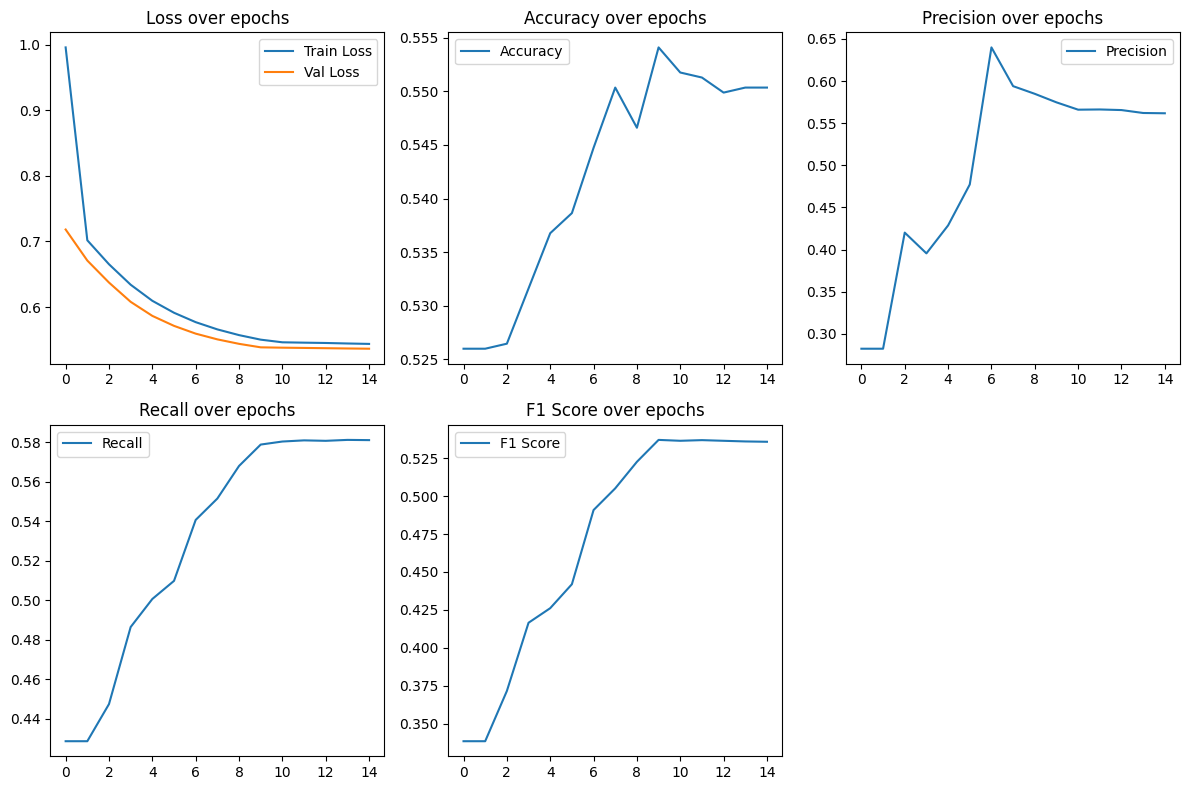

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 8))

    # plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    # plot precision
    plt.subplot(2, 3, 3)
    plt.plot(history['precision'], label='Precision')
    plt.title('Precision over epochs')
    plt.legend()

    # plot recall
    plt.subplot(2, 3, 4)
    plt.plot(history['recall'], label='Recall')
    plt.title('Recall over epochs')
    plt.legend()

    # plot F1 Score
    plt.subplot(2, 3, 5)
    plt.plot(history['f1'], label='F1 Score')
    plt.title('F1 Score over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(sbert_process_history)


In [ ]:
def load_model(path):
    model = SBertClassifier(embedding_dim, num_labels=7)
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    return model

# load the model
sentence_sbert_classifier_model = load_model('./sentence_sbert_model_path.pth')

def predict(text):
    with torch.no_grad():
        embeddings = sentence_sbert_model.encode([text], convert_to_tensor=True).to(device)
        outputs = sentence_sbert_classifier_model(embeddings)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.8
    return preds

sample_sentence = "We ensure the security of your personal data with up-to-date protocols."
sentence_sbert_prediction = predict(sample_sentence)
print("Prediction:", sentence_sbert_prediction)


Prediction: [[ True  True  True False False  True False]]


### BERT

In [ ]:
sentence_bert_tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
max_len = 512

# initialize the dataset
sentences_dataset = PrivacyPolicySentenceDataset(sentences_df['sentence_text'], sentences_df['sentence_labels'], sentence_bert_tokenizer, max_len)

sentence_bert_train_dataset, sentence_bert_eval_dataset = train_test_split(sentences_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_bert_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# add weight distribution to punish class imbalance
total_counts = sum(index_counts)
class_weights = [total_counts / count if count > 0 else 0 for count in index_counts]
max_weight = max(class_weights)
normalized_weights = [x / max_weight for x in class_weights]
weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

if torch.cuda.is_available():
    weights_tensor = weights_tensor.to('cuda')

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.BCEWithLogitsLoss(weight=weights_tensor)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

# initialize the model
sentence_bert_model = BertForSequenceClassification.from_pretrained('nlpaueb/legal-bert-base-uncased', num_labels=7)

# training arguments
sentence_bert_training_args = TrainingArguments(
    learning_rate=1e-5,
    output_dir='./sentence_bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_bert_logs',
    logging_steps=50,
    eval_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_bert_trainer = WeightedTrainer(
    model=sentence_bert_model,
    args=sentence_bert_training_args,
    train_dataset=sentence_bert_train_dataset,
    eval_dataset=sentence_bert_eval_dataset,
    compute_metrics=sentence_bert_compute_metrics
)

sentence_bert_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=3204, training_loss=0.06506116812892919, metrics={'train_runtime': 2550.8125, 'train_samples_per_second': 10.04, 'train_steps_per_second': 1.256, 'total_flos': 6738839751859200.0, 'train_loss': 0.06506116812892919, 'epoch': 3.0})

In [ ]:
sentence_bert_trainer.evaluate()


{'eval_loss': 0.057208407670259476,
 'eval_accuracy': 0.4313817330210773,
 'eval_precision': 0.7377930684293643,
 'eval_recall': 0.344584139772447,
 'eval_f1': 0.4450881385137535,
 'eval_runtime': 62.8409,
 'eval_samples_per_second': 33.975,
 'eval_steps_per_second': 2.132,
 'epoch': 3.0}

In [ ]:
# save the trained model
sentence_bert_model_path = "./sentence_bert_model"
sentence_bert_model.save_pretrained(sentence_bert_model_path)
sentence_bert_tokenizer.save_pretrained(sentence_bert_model_path)


('./sentence_bert_model/tokenizer_config.json',
 './sentence_bert_model/special_tokens_map.json',
 './sentence_bert_model/vocab.txt',
 './sentence_bert_model/added_tokens.json')

In [ ]:
!zip -r sentence_bert_logs.zip sentence_bert_logs/
!zip -r sentence_bert_results.zip sentence_bert_results/
!zip -r sentence_bert_model.zip sentence_bert_model/


  adding: sentence_bert_logs/ (stored 0%)
  adding: sentence_bert_logs/events.out.tfevents.1718218864.d912f3db20fb.4940.3 (deflated 65%)
  adding: sentence_bert_logs/events.out.tfevents.1718221541.d912f3db20fb.4940.4 (deflated 29%)
  adding: sentence_bert_results/ (stored 0%)
  adding: sentence_bert_results/checkpoint-2136/ (stored 0%)
  adding: sentence_bert_results/checkpoint-2136/config.json (deflated 55%)
  adding: sentence_bert_results/checkpoint-2136/model.safetensors (deflated 7%)
  adding: sentence_bert_results/checkpoint-2136/trainer_state.json (deflated 75%)
  adding: sentence_bert_results/checkpoint-2136/optimizer.pt


zip error: Interrupted (aborting)
  adding: sentence_bert_model/ (stored 0%)
  adding: sentence_bert_model/config.json (deflated 55%)
  adding: sentence_bert_model/model.safetensors (deflated 7%)
  adding: sentence_bert_model/tokenizer_config.json (deflated 75%)
  adding: sentence_bert_model/special_tokens_map.json (deflated 42%)
  adding: sentence_bert_model/

#### Plots

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


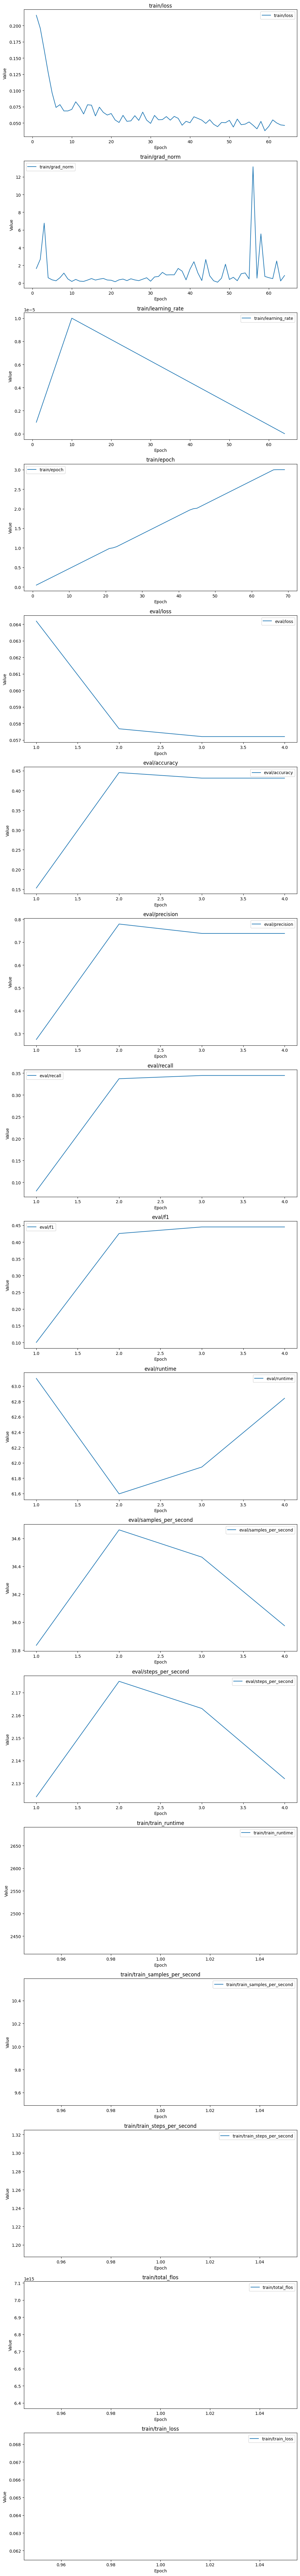

In [ ]:
sentence_bert_logdir = './sentence_bert_logs'

# Load the data
ea = event_accumulator.EventAccumulator(sentence_bert_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
sentence_bert_model = BertForSequenceClassification.from_pretrained(sentence_bert_model_path)
sentence_bert_tokenizer = BertTokenizer.from_pretrained(sentence_bert_model_path)

sentence_bert_classifier = pipeline("text-classification", model=sentence_bert_model, tokenizer=sentence_bert_tokenizer)

# sample text
# text = "Our site includes third-party advertising and links to other Web sites."
text = "We reveal only the last four digits of your credit card numbers when confirming an order."

# make predictions
sentence_bert_predictions = sentence_bert_classifier(text)

if sentence_bert_predictions:
    for pred in sentence_bert_predictions:
        label = label_descriptions.get(pred['label'], "Unknown Label")
        score = pred['score']
        print(f"Prediction: {label}, Score: {score:.4f}")


Prediction: Integrity and Confidentiality (Security), Score: 0.3314


### GPT2

In [ ]:
sentence_gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if sentence_gpt_tokenizer.pad_token is None:
    sentence_gpt_tokenizer.pad_token = sentence_gpt_tokenizer.eos_token

max_len = 512

# initialize the dataset
sentences_dataset = PrivacyPolicySentenceDataset(sentences_df['sentence_text'], sentences_df['sentence_labels'], sentence_gpt_tokenizer, max_len)

sentence_gpt_train_dataset, sentence_gpt_eval_dataset = train_test_split(sentences_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sentence_gpt_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# add weight distribution to punish class imbalance
total_counts = sum(index_counts)
class_weights = [total_counts / count if count > 0 else 0 for count in index_counts]
max_weight = max(class_weights)
normalized_weights = [x / max_weight for x in class_weights]
weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

if torch.cuda.is_available():
    weights_tensor = weights_tensor.to('cuda')

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        if 'loss' not in outputs:
            labels = inputs.get("labels")
            logits = outputs.get('logits')
            loss_fct = torch.nn.BCEWithLogitsLoss(weight=weights_tensor)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.float().view(-1, self.model.config.num_labels))
        else:
            loss = outputs['loss']

        return (loss, outputs) if return_outputs else loss

# initialize the model
sentence_gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', pad_token_id=sentence_gpt_tokenizer.eos_token_id, num_labels=7)
sentence_gpt_model.resize_token_embeddings(len(sentence_gpt_tokenizer))

# training arguments
sentence_gpt_training_args = TrainingArguments(
    learning_rate=2e-5,
    output_dir='./sentence_gpt_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./sentence_gpt_logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
sentence_gpt_trainer = WeightedTrainer(
    model=sentence_gpt_model,
    args=sentence_gpt_training_args,
    train_dataset=sentence_gpt_train_dataset,
    eval_dataset=sentence_gpt_eval_dataset,
    compute_metrics=sentence_gpt_compute_metrics
)

sentence_gpt_trainer.train()


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=3204, training_loss=0.25456324379691175, metrics={'train_runtime': 3036.6952, 'train_samples_per_second': 8.434, 'train_steps_per_second': 1.055, 'total_flos': 6692373199060992.0, 'train_loss': 0.25456324379691175, 'epoch': 3.0})

In [ ]:
sentence_gpt_trainer.evaluate()


{'eval_loss': 0.2562997341156006,
 'eval_accuracy': 0.6271662763466043,
 'eval_precision': 0.6931919812141675,
 'eval_recall': 0.515697309996452,
 'eval_f1': 0.5566175202663903,
 'eval_runtime': 79.6165,
 'eval_samples_per_second': 26.816,
 'eval_steps_per_second': 1.683,
 'epoch': 3.0}

In [ ]:
# save the trained model
sentence_gpt_model_path = "./sentence_gpt_model"
sentence_gpt_model.save_pretrained(sentence_gpt_model_path)
sentence_gpt_tokenizer.save_pretrained(sentence_gpt_model_path)


('./sentence_gpt_model/tokenizer_config.json',
 './sentence_gpt_model/special_tokens_map.json',
 './sentence_gpt_model/vocab.json',
 './sentence_gpt_model/merges.txt',
 './sentence_gpt_model/added_tokens.json')

In [ ]:
!zip -r sentence_gpt_logs.zip sentence_gpt_logs/
!zip -r sentence_gpt_results.zip sentence_gpt_results/
!zip -r sentence_gpt_model.zip sentence_gpt_model/


  adding: sentence_gpt_logs/ (stored 0%)
  adding: sentence_gpt_logs/events.out.tfevents.1718025215.be3b632f987b.1757.11 (deflated 65%)
  adding: sentence_gpt_logs/events.out.tfevents.1718028347.be3b632f987b.1757.12 (deflated 30%)
  adding: sentence_gpt_results/ (stored 0%)
  adding: sentence_gpt_results/checkpoint-2136/ (stored 0%)
  adding: sentence_gpt_results/checkpoint-2136/config.json (deflated 57%)
  adding: sentence_gpt_results/checkpoint-2136/model.safetensors (deflated 7%)
  adding: sentence_gpt_results/checkpoint-2136/trainer_state.json (deflated 75%)
  adding: sentence_gpt_results/checkpoint-2136/optimizer.pt (deflated 33%)
  adding: sentence_gpt_results/checkpoint-2136/training_args.bin (deflated 52%)
  adding: sentence_gpt_results/checkpoint-2136/scheduler.pt (deflated 56%)
  adding: sentence_gpt_results/checkpoint-2136/rng_state.pth (deflated 25%)
  adding: sentence_gpt_results/checkpoint-3204/ (stored 0%)
  adding: sentence_gpt_results/checkpoint-3204/config.json (defla

#### Plots

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


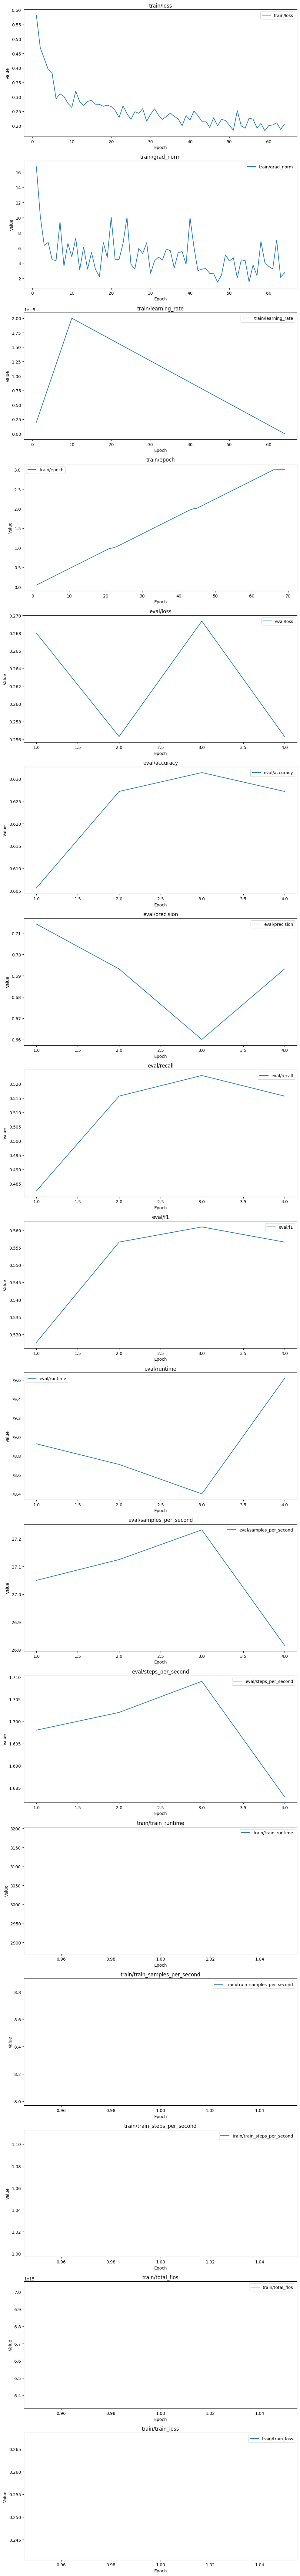

In [ ]:
sentence_gpt_logdir = './sentence_gpt_logs'

# Load the data
ea = event_accumulator.EventAccumulator(sentence_gpt_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
sentence_gpt_model = GPT2ForSequenceClassification.from_pretrained(sentence_gpt_model_path)
sentence_gpt_tokenizer = GPT2Tokenizer.from_pretrained(sentence_gpt_model_path)

sentence_gpt_classifier = pipeline("text-classification", model=sentence_gpt_model, tokenizer=sentence_gpt_tokenizer)

# sample text
# text = "Our site includes third-party advertising and links to other Web sites."
text = "We reveal only the last four digits of your credit card numbers when confirming an order."

# make predictions
sentence_gpt_predictions = sentence_gpt_classifier(text)

if sentence_gpt_predictions:
    for pred in sentence_gpt_predictions:
        label = label_descriptions.get(pred['label'], "Unknown Label")
        score = pred['score']
        print(f"Prediction: {label}, Score: {score:.4f}")


Prediction: Integrity and Confidentiality (Security), Score: 0.6080


## ACL-Coling Dataset

In [ ]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = ' '.join(text.split()).lower()
    return text

def extract_sentences(text):
    doc = nlp(text)
    return [preprocess_text(sent.text) for sent in doc.sents]

preprocessed_policies_sentences = []
directory = './acl_corpus/corpus/'

for filename in tqdm(os.listdir(directory), desc="Processing files"):
    if filename.endswith('.xml'):
        path = os.path.join(directory, filename)
        tree = ET.parse(path)
        root = tree.getroot()

        policy_sentences = []
        for section in root.findall('.//SECTION/SUBTEXT'):
            if section.text:
                sentences = extract_sentences(section.text)
                policy_sentences.extend(sentences)

        if policy_sentences:
            preprocessed_policies_sentences.append(policy_sentences)
        else:
            print(f"No meaningful content found in {filename}, policy skipped.")

print(f"Number of processed privacy policies: {len(preprocessed_policies_sentences)}")


Processing files: 100%|██████████| 1011/1011 [06:08<00:00,  2.74it/s]

Number of processed privacy policies: 1010


### SBERT (saved model)

In [ ]:
def load_model(path):
    model = SBertClassifier(embedding_dim, num_labels=7)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

sentence_sbert_classifier_model = load_model('./sentence_sbert_model_path.pth')
sentence_sbert_classifier_model.to(device)


SBertClassifier(
  (lstm): LSTM(384, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

In [ ]:
def sentence_sbert_classify_policy(policy_sentences, classifier, threshold=0.8):
    results = []
    unique_labels = set()

    for sentence in policy_sentences:
        if len(sentence.split()) > 11:
            embedding = sentence_sbert_model.encode(sentence, convert_to_tensor=True).to(device)

            with torch.no_grad():
                outputs = classifier(embedding.unsqueeze(0))
                probs = torch.sigmoid(outputs).squeeze(0)

            sentence_labels = []
            probs = probs.cpu().numpy()
            for idx, score in enumerate(probs):
                if score >= threshold:
                    label = sbert_label_descriptions.get(idx, "Unknown Label")
                    sentence_labels.append((label, score))
                    unique_labels.add(label)

            results.append((sentence, sentence_labels))
    return results, unique_labels


In [ ]:
policy_results, unique_labels = sentence_sbert_classify_policy(preprocessed_policies_sentences[100], sentence_sbert_classifier_model, threshold=0.8)

print("Policy Classification Results:")
for sentence, labels in policy_results:
    print(f"Sentence: {sentence}")
    for label, score in labels:
        print(f"  Prediction: {label}, Score: {score:.4f}")
    print()

print("\nUnique GDPR Labels identified in this policy:")
for label in unique_labels:
    print(label)


Policy Classification Results:
Sentence: privacy policy the science website is maintained by the american association for the advancement of science (aaas), 1200 new york avenue, nw, washington, dc 20005.
  Prediction: Data Minimization, Score: 0.8218

Sentence: this privacy statement sets forth the online data collection and usage policies and practices that apply to the science family of websites (also referred to as "science online" or the "science websites"), currently including science (online version), science classic, science express, sciencenow, sage ke, science signaling, science translational medicine, and science careers.
  Prediction: Data Minimization, Score: 0.8509

Sentence: it also includes the order forms and member services accessible from those websites.
  Prediction: Data Minimization, Score: 0.9657
  Prediction: Lawfulness, Fairness and Transparency, Score: 0.9258
  Prediction: Purpose Limitation, Score: 0.9257

Sentence: your data will be stored and processed in w

### BERT (saved model)

In [ ]:
# load the model and tokenizer
sentence_bert_model = BertForSequenceClassification.from_pretrained(sentence_bert_model_path)
sentence_bert_tokenizer = BertTokenizer.from_pretrained(sentence_bert_model_path)

sentence_bert_model.config.output_hidden_states = True


In [ ]:
sentence_bert_classifier = pipeline("text-classification", model=sentence_bert_model, tokenizer=sentence_bert_tokenizer)

def sentence_bert_classify_policy(policy_sentences, threshold=0.8):
    results = []
    unique_labels = set()
    for sentence in policy_sentences:
        if len(sentence.split()) > 11:
            predictions = sentence_bert_classifier(sentence)
            sentence_labels = []
            for pred in predictions:
                if pred['score'] >= threshold:
                    label = label_descriptions.get(pred['label'], "Unknown Label")
                    sentence_labels.append((label, pred['score']))
                    unique_labels.add(label)
            results.append((sentence, sentence_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies_sentences:
    policy_results, unique_labels = sentence_bert_classify_policy(preprocessed_policies_sentences[100], threshold=0.8)

    print("Policy Classification Results:")
    for sentence, labels in policy_results:
        print(f"Sentence: {sentence}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Sentence: privacy policy the science website is maintained by the american association for the advancement of science (aaas), 1200 new york avenue, nw, washington, dc 20005.

Sentence: this privacy statement sets forth the online data collection and usage policies and practices that apply to the science family of websites (also referred to as "science online" or the "science websites"), currently including science (online version), science classic, science express, sciencenow, sage ke, science signaling, science translational medicine, and science careers.

Sentence: it also includes the order forms and member services accessible from those websites.

Sentence: your data will be stored and processed in whole or in part in the united states.

Sentence: if you access the science website outside the united states, your usage of that site constitutes consent to the transfer of your data out of your country and to the united states.

Sentence: the science webs

### GPT2 (saved model)

In [ ]:
# load the model and tokenizer
sentence_gpt_model = GPT2ForSequenceClassification.from_pretrained(sentence_gpt_model_path)
sentence_gpt_tokenizer = GPT2Tokenizer.from_pretrained(sentence_gpt_model_path)

sentence_gpt_model.config.output_hidden_states = True


In [ ]:
sentence_gpt_classifier = pipeline("text-classification", model=sentence_gpt_model, tokenizer=sentence_gpt_tokenizer)

def sentence_gpt_classify_policy(policy_sentences, threshold=0.8):
    results = []
    unique_labels = set()
    for sentence in policy_sentences:
        if len(sentence.split()) > 11:
            predictions = sentence_gpt_classifier(sentence)
            sentence_labels = []
            for pred in predictions:
                if pred['score'] >= threshold:
                    label = label_descriptions.get(pred['label'], "Unknown Label")
                    sentence_labels.append((label, pred['score']))
                    unique_labels.add(label)
            results.append((sentence, sentence_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies_sentences:
    policy_results, unique_labels = sentence_gpt_classify_policy(preprocessed_policies_sentences[100], threshold=0.8)

    print("Policy Classification Results:")
    for sentence, labels in policy_results:
        print(f"Sentence: {sentence}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Sentence: privacy policy the science website is maintained by the american association for the advancement of science (aaas), 1200 new york avenue, nw, washington, dc 20005.

Sentence: this privacy statement sets forth the online data collection and usage policies and practices that apply to the science family of websites (also referred to as "science online" or the "science websites"), currently including science (online version), science classic, science express, sciencenow, sage ke, science signaling, science translational medicine, and science careers.

Sentence: it also includes the order forms and member services accessible from those websites.

Sentence: your data will be stored and processed in whole or in part in the united states.
  Prediction: Lawfulness, Fairness, and Transparency, Score: 0.8487

Sentence: if you access the science website outside the united states, your usage of that site constitutes consent to the transfer of your data out o

# Policy Level

In [ ]:
policies_df = pd.read_csv('./policies_gdpr_labels.csv')
policies_df['policies_labels'] = policies_df['policies_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
policies_df.head()


source                                      policies_text  \
0          google.com    welcome to the google privacy policy        ...   
1           style.com    vi.privacy policy          the type of infor...   
2   cariboucoffee.com  your privacy     |||caribou coffee privacy sta...   
3         thehill.com    the hill 's privacy policy        this priva...   
4  washingtonpost.com  publish january 1 2015     |||the wp company l...   

                                          categories        policies_labels  \
0  ['Data Security', 'Other', 'User Choice/Contro...  [1, 1, 1, 1, 1, 1, 0]   
1  ['Data Security', 'Do Not Track', 'Other', 'Us...  [1, 1, 1, 1, 0, 1, 0]   
2  ['Data Security', 'Other', 'User Choice/Contro...  [1, 1, 1, 1, 1, 1, 0]   
3  ['Data Security', 'Other', 'User Choice/Contro...  [1, 1, 1, 1, 1, 1, 0]   
4  ['Data Security', 'Do Not Track', 'Other', 'Us...  [1, 1, 1, 1, 0, 1, 0]   

   compliance_percentage  
0              85.714286  
1              71.428571  
2              85.714286  
3              85.714286  
4              71.428571

## OPP-115 Dataset

In [ ]:
n_gdpr = 7  # number of GDPR categories

index_counts = [0] * n_gdpr

for labels in policies_df['policies_labels']:
    for i in range(n_gdpr):
        if labels[i] == 1:
            index_counts[i] += 1

for i, count in enumerate(index_counts):
    print(f"(GDPR Principle {i+1}) count: {count}")

(GDPR Principle 1) count: 115
(GDPR Principle 2) count: 115
(GDPR Principle 3) count: 115
(GDPR Principle 4) count: 90
(GDPR Principle 5) count: 76
(GDPR Principle 6) count: 102
(GDPR Principle 7) count: 0


In [ ]:
class PrivacyPolicyDataset(Dataset):
    def __init__(self, policies_text, labels, tokenizer, max_len):
        """
        Args:
            policies_text (list of str): Texts of multiple policies.
            labels (list of list of int): Labels for each policy.
            tokenizer: Tokenizer to be used for encoding the text.
            max_len (int): Maximum length of the tokens.
        """
        self.tokenizer = tokenizer
        self.policies_text = policies_text
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.policies_text)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.policies_text[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


### SBERT

In [ ]:
# load SBERT model
policy_sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def policy_sbert_generate_embeddings(texts):
    embeddings = policy_sbert_model.encode(texts, convert_to_tensor=True)
    return embeddings


def policy_sbert_calculate_metrics(preds, labels, threshold=0.8):
    preds = preds > threshold
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return accuracy, precision, recall, f1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, threshold=0.8):
    history = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                total_eval_loss += loss.item()
                preds = torch.sigmoid(outputs).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        accuracy, precision, recall, f1 = policy_sbert_calculate_metrics(all_preds, all_labels, threshold)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    return model, history


In [ ]:
class SBertPolicyClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels, hidden_dim=256):
        super(SBertPolicyClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2 * hidden_dim, num_labels)

    def attention_net(self, lstm_output):
        attention_scores = torch.tanh(self.attention(lstm_output))
        return F.softmax(attention_scores, dim=1)

    def forward(self, embeddings):
        lstm_out, (hidden, _) = self.lstm(embeddings.unsqueeze(1))
        attention_weights = self.attention_net(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out

# initialize the datatset
policy_sbert_dataset = SBERTEmbeddingDataset(policies_df['policies_text'].tolist(), policies_df['policies_labels'].tolist())
policy_sbert_train_dataset, policy_sbert_eval_dataset = train_test_split(policy_sbert_dataset, test_size=0.2)

policy_sbert_train_loader = DataLoader(policy_sbert_train_dataset, batch_size=16, shuffle=True)
policy_sbert_val_loader = DataLoader(policy_sbert_eval_dataset, batch_size=16, shuffle=False)

# Ensure policies_labels is a numpy array
policies_labels = np.array(policies_df['policies_labels'].tolist())

# Calculate class counts
class_counts = [np.sum(policies_labels[:, i]) for i in range(n_gdpr)]
total_samples = len(policies_labels)

# Calculate class weights for binary classification
class_weights = [total_samples / (2 * count) if count > 0 else 0 for count in class_counts]

# Convert class weights to tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)

# Initialize the criterion with pos_weight
policy_sbert_criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)

# Initialize and train the model
embedding_dim = policy_sbert_model.get_sentence_embedding_dimension()
policy_sbert_classifier_model = SBertClassifier(embedding_dim, num_labels=7).to(device)
policy_sbert_optimizer = Adam(policy_sbert_classifier_model.parameters(), lr=1e-4)

# Start the training process
trained_model, sbert_process_history = train(policy_sbert_classifier_model, policy_sbert_train_loader,
                      policy_sbert_val_loader, policy_sbert_optimizer,
                      policy_sbert_criterion, epochs=10, device=device, threshold=0.8)



Epoch 1: Train Loss: 0.4609, Val Loss: 0.4486
Accuracy: 0.0870, Precision: 0.6770, Recall: 0.7143, F1: 0.6937
Epoch 2: Train Loss: 0.4581, Val Loss: 0.4455
Accuracy: 0.0870, Precision: 0.6770, Recall: 0.7143, F1: 0.6937
Epoch 3: Train Loss: 0.4548, Val Loss: 0.4422
Accuracy: 0.2609, Precision: 0.7791, Recall: 0.7519, F1: 0.7486
Epoch 4: Train Loss: 0.4524, Val Loss: 0.4387
Accuracy: 0.6087, Precision: 0.7927, Recall: 0.8421, F1: 0.8151
Epoch 5: Train Loss: 0.4486, Val Loss: 0.4352
Accuracy: 0.6522, Precision: 0.7950, Recall: 0.8571, F1: 0.8229
Epoch 6: Train Loss: 0.4449, Val Loss: 0.4313
Accuracy: 0.6522, Precision: 0.7950, Recall: 0.8571, F1: 0.8229
Epoch 7: Train Loss: 0.4415, Val Loss: 0.4271
Accuracy: 0.6522, Precision: 0.7950, Recall: 0.8571, F1: 0.8229
Epoch 8: Train Loss: 0.4374, Val Loss: 0.4227
Accuracy: 0.6522, Precision: 0.7950, Recall: 0.8571, F1: 0.8229
Epoch 9: Train Loss: 0.4331, Val Loss: 0.4178
Accuracy: 0.6522, Precision: 0.7950, Recall: 0.8571, F1: 0.8229
Epoch 10: 

In [ ]:
# save the trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(policy_sbert_classifier_model, './policy_sbert_model_path.pth')


In [ ]:
!zip -r policy_sbert_model.zip policy_sbert_model/


### BERT

In [ ]:
policy_bert_tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
max_len = 512

# initialize the dataset
policies_dataset = PrivacyPolicyDataset(policies_df['policies_text'], policies_df['policies_labels'], policy_bert_tokenizer, max_len)

policy_bert_train_dataset, policy_bert_eval_dataset = train_test_split(policies_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def policy_bert_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# initialize the model
policy_bert_model = BertForSequenceClassification.from_pretrained('nlpaueb/legal-bert-base-uncased', num_labels=7)

# training arguments
policy_bert_training_args = TrainingArguments(
    learning_rate=1e-5,
    output_dir='./policy_bert_results',
    num_train_epochs=25,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./policy_bert_logs',
    logging_steps=50,
    eval_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
policy_bert_trainer = Trainer(
    model=policy_bert_model,
    args=policy_bert_training_args,
    train_dataset=policy_bert_train_dataset,
    eval_dataset=policy_bert_eval_dataset,
    compute_metrics=policy_bert_compute_metrics
)

policy_bert_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=300, training_loss=0.3853708648681641, metrics={'train_runtime': 305.1825, 'train_samples_per_second': 7.536, 'train_steps_per_second': 0.983, 'total_flos': 605182594560000.0, 'train_loss': 0.3853708648681641, 'epoch': 25.0})

In [ ]:
policy_bert_trainer.evaluate()


{'eval_loss': 0.22524061799049377,
 'eval_accuracy': 0.13043478260869565,
 'eval_precision': 0.7012987012987013,
 'eval_recall': 0.6571428571428571,
 'eval_f1': 0.6717687074829932,
 'eval_runtime': 0.7421,
 'eval_samples_per_second': 30.994,
 'eval_steps_per_second': 2.695,
 'epoch': 25.0}

In [ ]:
# save the trained model
policy_bert_model_path = "./policy_bert_model"
policy_bert_model.save_pretrained(policy_bert_model_path)
policy_bert_tokenizer.save_pretrained(policy_bert_model_path)


('./policy_bert_model/tokenizer_config.json',
 './policy_bert_model/special_tokens_map.json',
 './policy_bert_model/vocab.txt',
 './policy_bert_model/added_tokens.json')

In [ ]:
!zip -r policy_bert_logs.zip policy_bert_logs/
!zip -r policy_bert_results.zip policy_bert_results/
!zip -r policy_bert_model.zip policy_bert_model/


  adding: policy_bert_logs/ (stored 0%)
  adding: policy_bert_logs/events.out.tfevents.1718216678.d912f3db20fb.4940.1 (deflated 66%)
  adding: policy_bert_logs/events.out.tfevents.1718216542.d912f3db20fb.4940.0 (deflated 63%)
  adding: policy_bert_logs/events.out.tfevents.1718217047.d912f3db20fb.4940.2 (deflated 29%)
  adding: policy_bert_results/ (stored 0%)
  adding: policy_bert_results/checkpoint-240/ (stored 0%)
  adding: policy_bert_results/checkpoint-240/config.json (deflated 55%)
  adding: policy_bert_results/checkpoint-240/model.safetensors (deflated 7%)
  adding: policy_bert_results/checkpoint-240/trainer_state.json (deflated 82%)
  adding: policy_bert_results/checkpoint-240/optimizer.pt (deflated 26%)
  adding: policy_bert_results/checkpoint-240/scheduler.pt (deflated 56%)
  adding: policy_bert_results/checkpoint-240/training_args.bin (deflated 52%)
  adding: policy_bert_results/checkpoint-240/rng_state.pth (deflated 25%)
  adding: policy_bert_results/checkpoint-264/ (stored 

#### Plots

['eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/epoch', 'train/loss', 'train/grad_norm', 'train/learning_rate', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


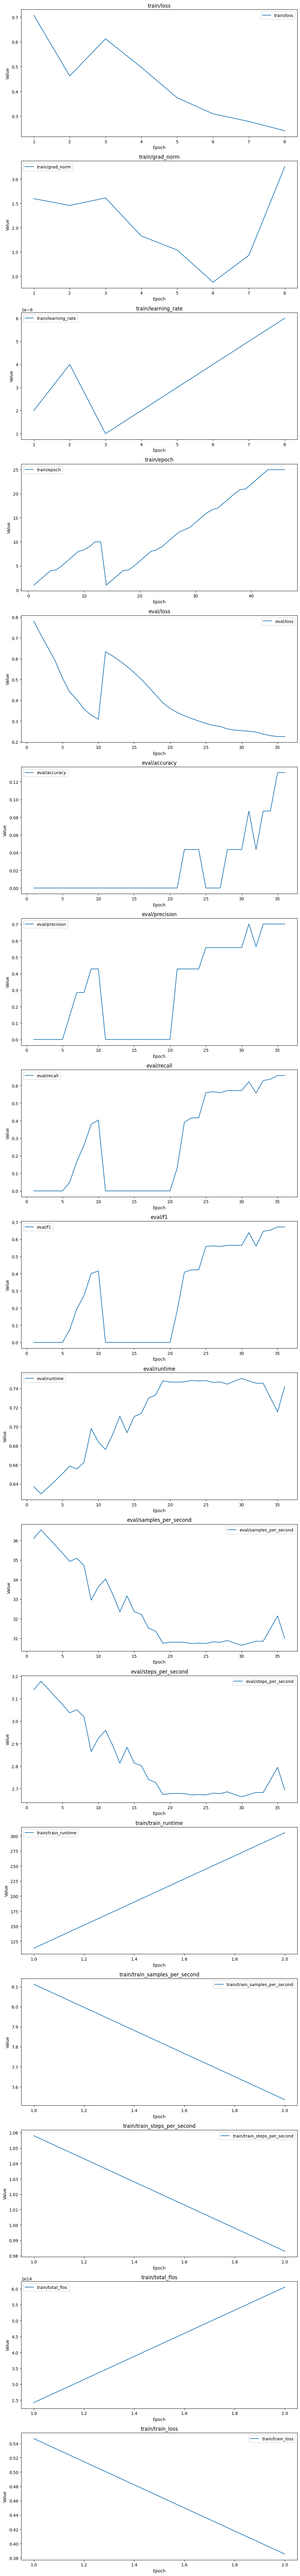

In [ ]:
policy_bert_logdir = './policy_bert_logs'

# load the data
ea = event_accumulator.EventAccumulator(policy_bert_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
policy_bert_model = BertForSequenceClassification.from_pretrained(policy_bert_model_path)
policy_bert_tokenizer = BertTokenizer.from_pretrained(policy_bert_model_path)

policy_bert_classifier = pipeline("text-classification", model=policy_bert_model, tokenizer=policy_bert_tokenizer)

# sample text
# text = "Our site includes third-party advertising and links to other Web sites."
text = "We reveal only the last four digits of your credit card numbers when confirming an order."

# make predictions
policy_bert_predictions = policy_bert_classifier(text)

if policy_bert_predictions:
    for pred in policy_bert_predictions:
        label = label_descriptions.get(pred['label'], "Unknown Label")
        score = pred['score']
        print(f"Prediction: {label}, Score: {score:.4f}")


Prediction: Data Minimization, Score: 0.6556


### GPT2

In [ ]:
policy_gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if policy_gpt_tokenizer.pad_token is None:
    policy_gpt_tokenizer.pad_token = policy_gpt_tokenizer.eos_token
max_len = 512

# initialize the dataset
policies_dataset = PrivacyPolicyDataset(policies_df['policies_text'], policies_df['policies_labels'], policy_gpt_tokenizer, max_len)

policy_gpt_train_dataset, policy_gpt_eval_dataset = train_test_split(policies_dataset, test_size=0.2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def policy_gpt_compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > 0.8).astype(int)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# initialize the model
policy_gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', pad_token_id=policy_gpt_tokenizer.eos_token_id, num_labels=7)
policy_gpt_model.resize_token_embeddings(len(policy_gpt_tokenizer))

# training arguments
policy_gpt_training_args = TrainingArguments(
    learning_rate=5e-5,
    output_dir='./policy_gpt_results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./policy_gpt_logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# initialize the trainer
policy_gpt_trainer = Trainer(
    model=policy_gpt_model,
    args=policy_gpt_training_args,
    train_dataset=policy_gpt_train_dataset,
    eval_dataset=policy_gpt_eval_dataset,
    compute_metrics=policy_gpt_compute_metrics
)

policy_gpt_trainer.train()


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=69, training_loss=0.8351341606914133, metrics={'train_runtime': 44.6736, 'train_samples_per_second': 6.178, 'train_steps_per_second': 1.545, 'total_flos': 72121158991872.0, 'train_loss': 0.8351341606914133, 'epoch': 3.0})

In [ ]:
policy_gpt_trainer.evaluate()


{'eval_loss': 0.4389045536518097,
 'eval_accuracy': 0.08695652173913043,
 'eval_precision': 0.836734693877551,
 'eval_recall': 0.5979078130107879,
 'eval_f1': 0.6591418917000312,
 'eval_runtime': 0.9595,
 'eval_samples_per_second': 23.971,
 'eval_steps_per_second': 6.253,
 'epoch': 3.0}

In [ ]:
# save the trained model
policy_gpt_model_path = "./policy_gpt_model"
policy_gpt_model.save_pretrained(policy_gpt_model_path)
policy_gpt_tokenizer.save_pretrained(policy_gpt_model_path)


('./policy_gpt_model/tokenizer_config.json',
 './policy_gpt_model/special_tokens_map.json',
 './policy_gpt_model/vocab.json',
 './policy_gpt_model/merges.txt',
 './policy_gpt_model/added_tokens.json')

In [ ]:
!zip -r policy_gpt_logs.zip policy_gpt_logs/
!zip -r policy_gpt_results.zip policy_gpt_results/
!zip -r policy_gpt_model.zip policy_gpt_model/


  adding: policy_gpt_logs/ (stored 0%)
  adding: policy_gpt_logs/events.out.tfevents.1718035278.be3b632f987b.1757.15 (deflated 60%)
  adding: policy_gpt_logs/events.out.tfevents.1718035324.be3b632f987b.1757.16 (deflated 29%)
  adding: policy_gpt_results/ (stored 0%)
  adding: policy_gpt_results/checkpoint-46/ (stored 0%)
  adding: policy_gpt_results/checkpoint-46/config.json (deflated 57%)
  adding: policy_gpt_results/checkpoint-46/model.safetensors (deflated 7%)
  adding: policy_gpt_results/checkpoint-46/trainer_state.json (deflated 61%)
  adding: policy_gpt_results/checkpoint-46/optimizer.pt (deflated 35%)
  adding: policy_gpt_results/checkpoint-46/training_args.bin (deflated 52%)
  adding: policy_gpt_results/checkpoint-46/scheduler.pt (deflated 56%)
  adding: policy_gpt_results/checkpoint-46/rng_state.pth (deflated 25%)
  adding: policy_gpt_results/checkpoint-23/ (stored 0%)
  adding: policy_gpt_results/checkpoint-23/config.json (deflated 57%)
  adding: policy_gpt_results/checkpoint

#### Plots

['eval/loss', 'eval/accuracy', 'eval/precision', 'eval/recall', 'eval/f1', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/epoch', 'train/loss', 'train/grad_norm', 'train/learning_rate', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


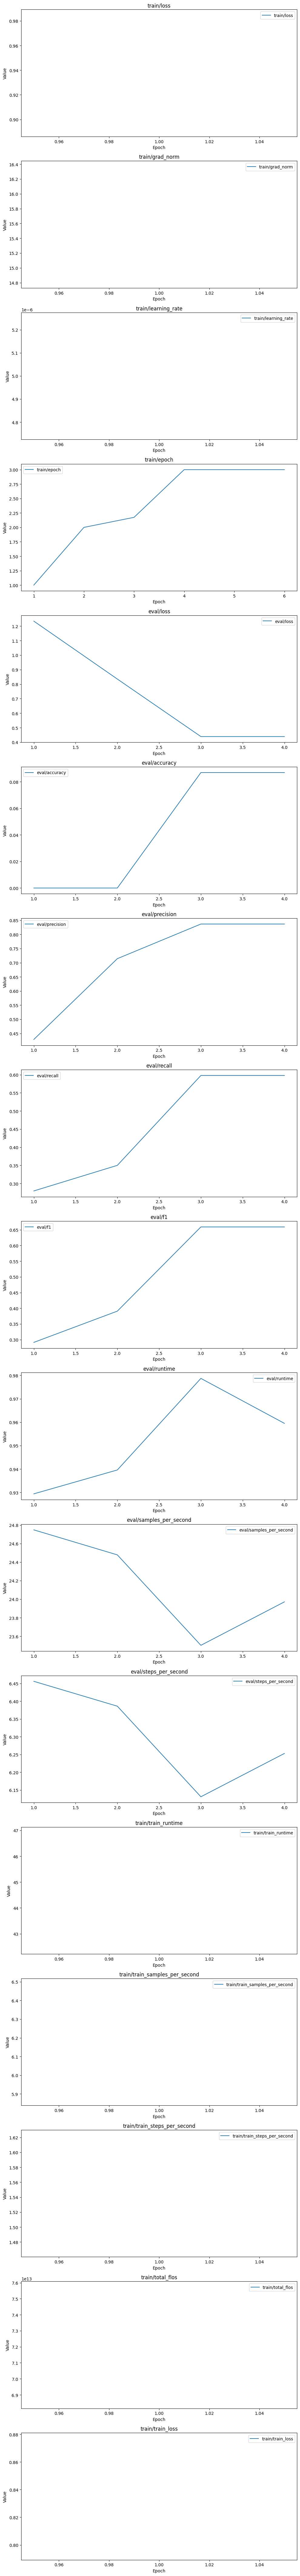

In [ ]:
policy_gpt_logdir = './policy_gpt_logs'

# Load the data
ea = event_accumulator.EventAccumulator(policy_gpt_logdir)
ea.Reload()

print(ea.Tags()['scalars'])

def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

metrics_dict = {key: extract_metric(key) for key in ['train/loss',
                                                     'train/grad_norm',
                                                     'train/learning_rate',
                                                     'train/epoch',
                                                     'eval/loss',
                                                     'eval/accuracy',
                                                     'eval/precision',
                                                     'eval/recall', 'eval/f1',
                                                     'eval/runtime',
                                                     'eval/samples_per_second',
                                                     'eval/steps_per_second',
                                                     'train/train_runtime',
                                                     'train/train_samples_per_second',
                                                     'train/train_steps_per_second',
                                                     'train/total_flos', 'train/train_loss']
}

num_plots = len(metrics_dict)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
axs = axs.flatten()

# plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
policy_gpt_model = GPT2ForSequenceClassification.from_pretrained(policy_gpt_model_path)
policy_gpt_tokenizer = GPT2Tokenizer.from_pretrained(policy_gpt_model_path)

policy_gpt_classifier = pipeline("text-classification", model=policy_gpt_model, tokenizer=policy_gpt_tokenizer)

# sample text
# text = "Our site includes third-party advertising and links to other Web sites."
text = "We reveal only the last four digits of your credit card numbers when confirming an order."

# make predictions
policy_gpt_predictions = policy_gpt_classifier(text)

if policy_gpt_predictions:
    for pred in policy_gpt_predictions:
        label = label_descriptions.get(pred['label'], "Unknown Label")
        score = pred['score']
        print(f"Prediction: {label}, Score: {score:.4f}")


Prediction: Lawfulness, Fairness, and Transparency, Score: 0.9614


## ACL-Coling Dataset

In [ ]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Preprocess the text by normalizing whitespace and converting to lowercase
    return ' '.join(text.split()).lower()

preprocessed_policies = []
directory = './acl_corpus/corpus/'

for filename in os.listdir(directory):
    if filename.endswith('.xml'):
        path = os.path.join(directory, filename)
        tree = ET.parse(path)
        root = tree.getroot()

        # Initialize a variable to hold the concatenated text of the policy
        full_policy_text = ""

        # Iterate over each section and concatenate text
        for section in root.findall('.//SECTION/SUBTEXT'):
            if section.text:
                full_policy_text += ' ' + section.text

        # Preprocess the concatenated text
        if full_policy_text:
            preprocessed_policy = preprocess_text(full_policy_text)
            preprocessed_policies.append(preprocessed_policy)
        else:
            print(f"No meaningful content found in {filename}, policy skipped.")

print(f"Number of processed privacy policies: {len(preprocessed_policies)}")


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Number of processed privacy policies: 1010


### SBERT (saved model)

In [ ]:
def load_model(path, embedding_dim):
    model = SBertClassifier(embedding_dim, num_labels=7)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

embedding_dim = 384
policy_sbert_classifier_model = load_model('./policy_sbert_model_path.pth', embedding_dim)
policy_sbert_classifier_model.to(device)


SBertClassifier(
  (lstm): LSTM(384, 256, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
def policy_sbert_classify_policy(policies, classifier, threshold=0.8):
    results = []
    unique_labels = set()

    for policy in policies:
        embedding = policy_sbert_model.encode(policy, convert_to_tensor=True).to(device)

        with torch.no_grad():
            outputs = classifier(embedding.unsqueeze(0))
            probs = torch.sigmoid(outputs).squeeze(0)

        policy_labels = []
        probs = probs.cpu().numpy()
        for idx, score in enumerate(probs):
            if score >= threshold:
                label = sbert_label_descriptions.get(idx, "Unknown Label")
                policy_labels.append((label, score))
                unique_labels.add(label)

        results.append((policy, policy_labels))
    return results, unique_labels


In [ ]:
policy_results, unique_labels = policy_sbert_classify_policy([preprocessed_policies[100]], policy_sbert_classifier_model, threshold=0.8)

print("Policy Classification Results:")
for policy, labels in policy_results:
    print(f"Policy: {policy}")
    for label, score in labels:
        print(f"  Prediction: {label}, Score: {score:.4f}")
    print()

print("\nUnique GDPR Labels identified in this policy:")
for label in unique_labels:
    print(label)


Policy Classification Results:
Policy: by submit personal information to we you acknowledge and agree that you have consent to the collection use and disclosure practice set out in this privacy policy as they relate to your personal information
  Prediction: Data Minimization, Score: 0.5418
  Prediction: Lawfulness, Fairness and Transparency, Score: 0.5383
  Prediction: Purpose Limitation, Score: 0.5490
  Prediction: Storage Limitation, Score: 0.5216
  Prediction: Data Security, Score: 0.5163
  Prediction: Accountability, Score: 0.5283


Unique GDPR Labels identified in this policy:
Storage Limitation
Accountability
Data Security
Purpose Limitation
Lawfulness, Fairness and Transparency
Data Minimization


### BERT (saved model)

In [ ]:
# load the model and tokenizer
policy_bert_model = BertForSequenceClassification.from_pretrained(policy_bert_model_path)
policy_bert_tokenizer = BertTokenizer.from_pretrained(policy_bert_model_path)

policy_bert_model.config.output_hidden_states = True


In [ ]:
policy_bert_classifier = pipeline("text-classification", model=policy_bert_model, tokenizer=policy_bert_tokenizer)

def policy_bert_classify_policy(policies, threshold=0.8):
    results = []
    unique_labels = set()
    for policy in policies:
        predictions = policy_bert_classifier(policy)
        policy_labels = []
        for pred in predictions:
            if pred['score'] >= threshold:
                label = label_descriptions.get(pred['label'], "Unknown Label")
                policy_labels.append((label, pred['score']))
                unique_labels.add(label)
        results.append((policy, policy_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies:
    policy_results, unique_labels = policy_bert_classify_policy([preprocessed_policies[100][:500]], threshold=0.8)

    print("Policy Classification Results:")
    for policy, labels in policy_results:
        print(f"Policy: {policy}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Policy: last modified: july 1, 2013 you have trusted us for many years to make safe and quality educational children's content that family members of all ages can enjoy. we understand how important privacy is to you and your family, which is why we are committed to creating a safe and secure environment that family members of all ages can enjoy. as a not-for-profit public institution, our goal is to collect only the information about our users and their use of our services that will help us provide the 
  Prediction: Purpose Limitation, Score: 0.8708


Unique GDPR Labels identified in this policy:
Purpose Limitation


### GPT2 (saved model)

In [ ]:
# load the model and tokenizer
policy_gpt_model = GPT2ForSequenceClassification.from_pretrained(policy_gpt_model_path)
policy_gpt_tokenizer = GPT2Tokenizer.from_pretrained(policy_gpt_model_path)

policy_gpt_model.config.output_hidden_states = True


In [ ]:
policy_gpt_classifier = pipeline("text-classification", model=policy_gpt_model, tokenizer=policy_gpt_tokenizer)

def policy_gpt_classify_policy(policies, threshold=0.8):
    results = []
    unique_labels = set()
    for policy in policies:
        predictions = policy_gpt_classifier(policy)
        policy_labels = []
        for pred in predictions:
            if pred['score'] >= threshold:
                label = label_descriptions.get(pred['label'], "Unknown Label")
                policy_labels.append((label, pred['score']))
                unique_labels.add(label)
        results.append((policy, policy_labels))
    return results, unique_labels

# processing and classifying one policy
if preprocessed_policies:
    policy_results, unique_labels = policy_gpt_classify_policy([preprocessed_policies[100]], threshold=0.8)

    print("Policy Classification Results:")
    for policy, labels in policy_results:
        print(f"Policy: {policy}")
        for label, score in labels:
            print(f"  Prediction: {label}, Score: {score:.4f}")
        print()

    print("\nUnique GDPR Labels identified in this policy:")
    for label in unique_labels:
        print(label)


Policy Classification Results:
Policy: by submit personal information to we you acknowledge and agree that you have consent to the collection use and disclosure practice set out in this privacy policy as they relate to your personal information
  Prediction: Lawfulness, Fairness, and Transparency, Score: 0.9462


Unique GDPR Labels identified in this policy:
Lawfulness, Fairness, and Transparency


# API models

## Sentence Level

### GPT ADA model

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": "Do you know about GDPR compliance? Specifically the principles from article 5 of the GDPR?"},
    {"role": "user", "content": "Hello!"}
  ]
)

display_open_ai_response(completion.choices[0].message.content)


Hello! Yes, I'm familiar with GDPR compliance, including the principles outlined in Article 5 of the General Data  
Protection Regulation (GDPR). Article 5 sets forth the core principles relating to the processing of personal data.
These principles serve as the foundational elements for GDPR compliance. They are:                                 

 1 Lawfulness, Fairness, and Transparency: Personal data must be processed lawfully, fairly, and in a transparent  
   manner in relation to the data subject.                                                                         
 2 Purpose Limitation: Personal data should be collected for specified, explicit, and legitimate purposes and not  
   further processed in a manner that is incompatible with those purposes.                                         
 3 Data Minimization: Personal data collected must be adequate, relevant, and limited to what is necessary in      
   relation to the purposes for which they are processed.                                                          
 4 Accuracy: Personal data must be accurate and, where necessary, kept up to date. Inaccurate personal data should 
   be erased or rectified without delay.                                                                           
 5 Storage Limitation: Personal data should be kept in a form which permits identification of data subjects for no 
   longer than is necessary for the purposes for which the personal data are processed.                            
 6 Integrity and Confidentiality: Personal data must be processed in a manner that ensures appropriate security,   
   including protection against unauthorized or unlawful processing and against accidental loss, destruction, or   
   damage, using appropriate technical or organizational measures.                                                 
 7 Accountability: The data controller is responsible for, and must be able to demonstrate compliance with, the    
   other six principles.                                                                                           

These principles are designed to protect individuals' privacy and personal data while also ensuring that           
organizations process data responsibly and transparently. Compliance with these principles is essential for any    
organization that processes personal data of individuals within the European Union.

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": """From the sentence: you may be able to direct your internet browser not to allow cookies and you can typically delete existing cookies from your computer at any time. Does it comply with any of the principles from the GDPR article 5? If yes, then which one(s)?"""},
    {"role": "user", "content": "Hello!"}
  ]
)

response = completion.choices[0].message.content
display_open_ai_response(response)


Hello! To address your question regarding the sentence "you may be able to direct your internet browser not to     
allow cookies and you can typically delete existing cookies from your computer at any time," let's analyze its     
compliance with the principles outlined in Article 5 of the General Data Protection Regulation (GDPR).             

Article 5 of the GDPR outlines the following key principles for the processing of personal data:                   

 1 Lawfulness, Fairness, and Transparency: Personal data must be processed lawfully, fairly, and in a transparent  
   manner.                                                                                                         
 2 Purpose Limitation: Personal data must be collected for specified, explicit, and legitimate purposes and not    
   further processed in a manner that is incompatible with those purposes.                                         
 3 Data Minimization: Personal data must be adequate, relevant, and limited to what is necessary in relation to the
   purposes for which they are processed.                                                                          
 4 Accuracy: Personal data must be accurate and, where necessary, kept up to date.                                 
 5 Storage Limitation: Personal data must be kept in a form which permits identification of data subjects for no   
   longer than is necessary for the purposes for which the personal data are processed.                            
 6 Integrity and Confidentiality: Personal data must be processed in a manner that ensures appropriate security of 
   the personal data, including protection against unauthorized or unlawful processing and against accidental loss,
   destruction, or damage.                                                                                         
 7 Accountability: The data controller is responsible for, and must be able to demonstrate, compliance with these  
   principles.                                                                                                     

The given sentence specifically addresses user control over cookies, which is related to:                          

 1 Transparency: Informing users that they can manage cookies directly through their browser settings and delete   
   them whenever they wish aligns with the principle of transparency. This means users are aware of their          
   capability to control cookies and hence their personal data.                                                    
 2 Integrity and Confidentiality: Allowing users to delete cookies at any time can contribute to better security   
   and protection of personal data. It means users have the ability to avoid potential unauthorized access to their
   data through cookies.                                                                                           
 3 Storage Limitation: Informing users that they can delete cookies aligns with the idea that personal data (which 
   cookies can sometimes be classified as) should not be kept for longer than necessary.                           

Therefore, the sentence complies with the principles of Transparency, Integrity and Confidentiality, and Storage   
Limitation from GDPR Article 5.

In [ ]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def get_ada_embeddings(texts):
    ada_embeddings = []
    for text in texts:
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=text,
            encoding_format="float"
        )
        ada_embeddings.append(response.data[0].embedding)
    return ada_embeddings


In [ ]:
class AdaPrivacyPolicyDataset(Dataset):
    def __init__(self, texts, labels):
        """
        Args:
            texts (list of str): List of sentence texts.
            labels (list of int): Corresponding labels for each text.
        """
        self.texts = texts
        self.labels = labels
        self.embeddings = get_ada_embeddings(self.texts)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embedding, label

ada_preprocessed_policies = sentences_df['sentence_text'].tolist()
ada_labels = sentences_df['sentence_labels'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(ada_preprocessed_policies, ada_labels, test_size=0.2)

train_dataset = AdaPrivacyPolicyDataset(train_texts, train_labels)
val_dataset = AdaPrivacyPolicyDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
def ada_compute_metrics(preds, labels):
    """
    Compute metrics like accuracy, precision, recall, and F1 score.
    Args:
        preds: Predictions from the model.
        labels: Actual labels.
    Returns:
        A dictionary with accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_labels)
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.output(x)
        return x


In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_f1': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        true_labels = []
        pred_labels = []

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted = outputs.squeeze().detach().cpu().numpy() > 0.8
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted)

        train_metrics = ada_compute_metrics(pred_labels, true_labels)
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        val_true_labels = []
        val_pred_labels = []

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs.squeeze(), labels.float())
                total_val_loss += loss.item()

                predicted = outputs.squeeze().detach().cpu().numpy() > 0.8
                val_true_labels.extend(labels.cpu().numpy())
                val_pred_labels.extend(predicted)

        val_metrics = ada_compute_metrics(val_pred_labels, val_true_labels)
        avg_val_loss = total_val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        for key in train_metrics:
            history['train_' + key].append(train_metrics[key])
            history['val_' + key].append(val_metrics[key])

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Train Metrics: {train_metrics}')
        print(f'Val Metrics: {val_metrics}')

    return model, history


In [ ]:
embedding_dim = 3072
num_labels = 7
ada_sentence_classifier_model = TextClassifier(embedding_dim, num_labels).to(device)

criterion = nn.BCELoss()
optimizer = Adam(ada_sentence_classifier_model.parameters(), lr=0.001)

ada_sentence_model, ada_sentence_history = train_and_validate(
    ada_sentence_classifier_model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device
)


Epoch 1/10, Train Loss: 0.2859, Val Loss: 0.2587
Train Metrics: {'accuracy': 0.4212562353659778, 'precision': 0.5385023691972628, 'recall': 0.22254247622551523, 'f1': 0.29305027078473644}
Val Metrics: {'accuracy': 0.4796416938110749, 'precision': 0.5348433362149073, 'recall': 0.2664654566704681, 'f1': 0.3477151157490585}
Epoch 2/10, Train Loss: 0.2337, Val Loss: 0.2485
Train Metrics: {'accuracy': 0.5465743662832129, 'precision': 0.6789188530250764, 'recall': 0.32500027961223293, 'f1': 0.403619610265944}
Val Metrics: {'accuracy': 0.5513029315960912, 'precision': 0.6636407802746863, 'recall': 0.33975280752371545, 'f1': 0.4188076470975145}
Epoch 3/10, Train Loss: 0.2224, Val Loss: 0.2450
Train Metrics: {'accuracy': 0.5681563677084394, 'precision': 0.814287553363504, 'recall': 0.35007891395582075, 'f1': 0.43554039775088665}
Val Metrics: {'accuracy': 0.5496742671009772, 'precision': 0.8043982412910082, 'recall': 0.3466900711319846, 'f1': 0.44090308029665515}
Epoch 4/10, Train Loss: 0.2138, 

In [ ]:
torch.save(ada_sentence_model, './ada_sentence_model.pth')


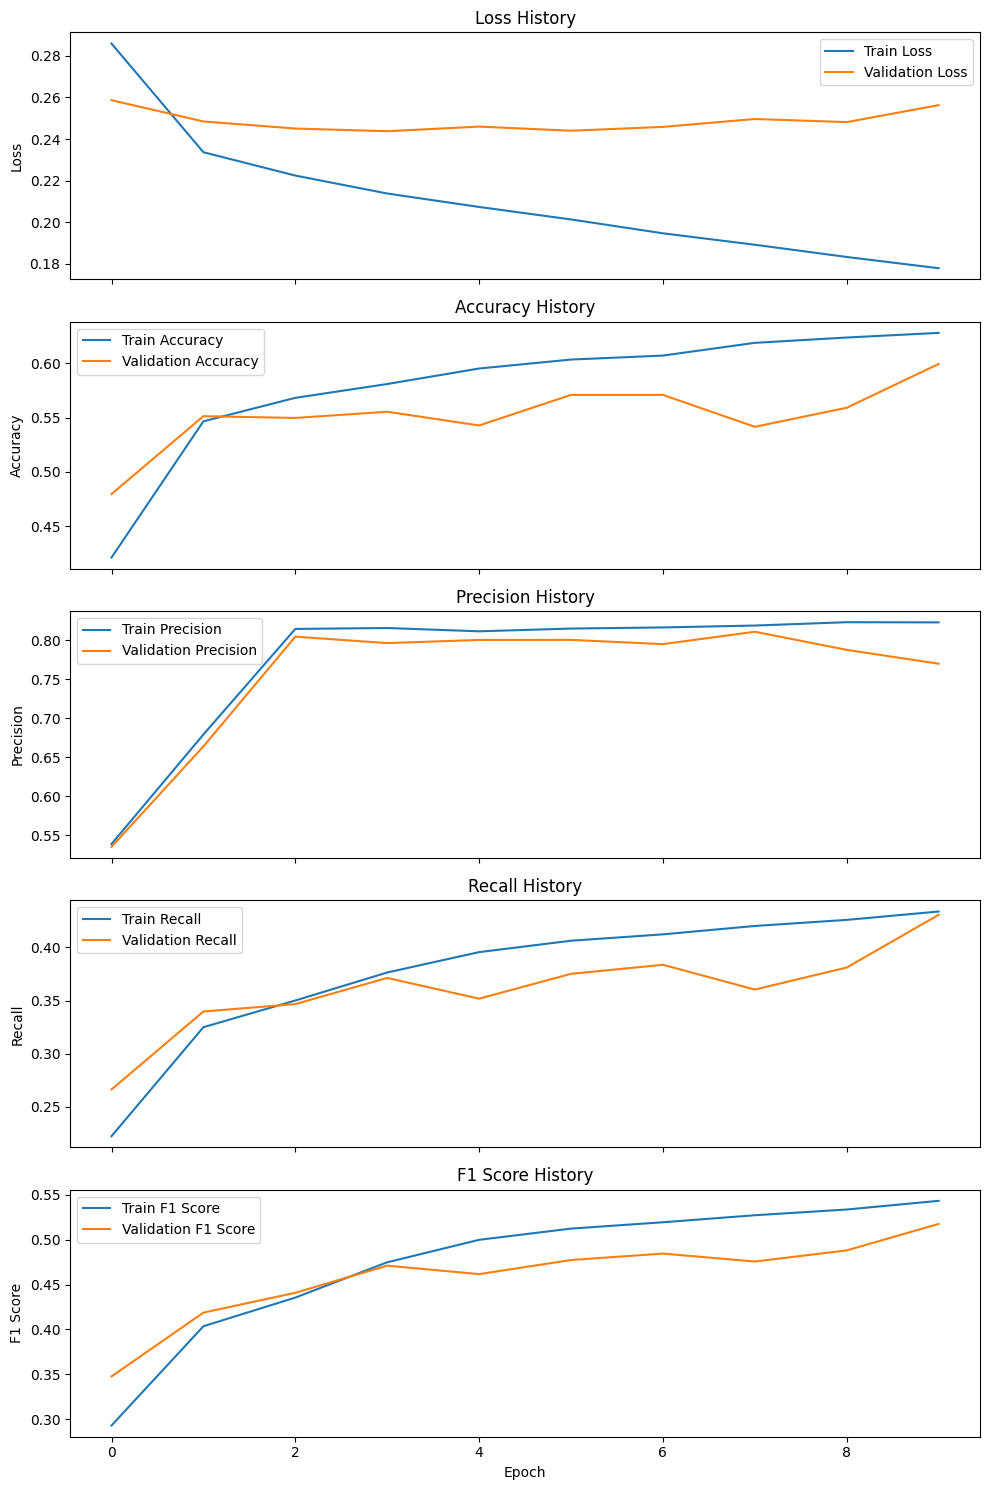

In [ ]:
def plot_history(history):
    num_plots = 5
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 3), sharex=True)

    axs[0].plot(history['train_loss'], label='Train Loss')
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss History')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history['train_accuracy'], label='Train Accuracy')
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy History')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    axs[2].plot(history['train_precision'], label='Train Precision')
    axs[2].plot(history['val_precision'], label='Validation Precision')
    axs[2].set_title('Precision History')
    axs[2].set_ylabel('Precision')
    axs[2].legend()

    axs[3].plot(history['train_recall'], label='Train Recall')
    axs[3].plot(history['val_recall'], label='Validation Recall')
    axs[3].set_title('Recall History')
    axs[3].set_ylabel('Recall')
    axs[3].legend()

    axs[4].plot(history['train_f1'], label='Train F1 Score')
    axs[4].plot(history['val_f1'], label='Validation F1 Score')
    axs[4].set_title('F1 Score History')
    axs[4].set_ylabel('F1 Score')
    axs[4].legend()

    axs[-1].set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

plot_history(ada_sentence_history)


In [ ]:
ada_sentence_model = torch.load('./ada_sentence_model.pth')
ada_sentence_model.to(device)
ada_sentence_model.eval()

def predict(text, model):
    model.eval()
    input_embeddings = get_ada_embeddings([text])
    embeddings = torch.tensor(input_embeddings[0], dtype=torch.float).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(embeddings)
        preds = (torch.sigmoid(outputs).cpu().numpy() > 0.8).astype(int)
    return preds


sample_sentence = "We ensure the security of your personal data with up-to-date protocols."
predicted_labels = predict(sample_sentence, ada_sentence_classifier_model)
print("Predicted Labels:", predicted_labels)


Predicted Labels: [[0 0 0 0 0 0 0]]


In [ ]:
print("done")

done
